# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install lightgbm==3.3.3 -q
!pip install imblearn -q
!pip install phik -q
!pip install mlxtend -q

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler
)
from sklearn.compose import make_column_transformer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error


plt.rcParams["figure.figsize"] = (15, 10)

warnings.filterwarnings("ignore")

RANDOM_STATE = 37
TEST_SIZE = 0.25

In [3]:
pth1 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16, color = 'olive')
            .set_title('Пример' + "\n", fontsize = 22, color = 'Blue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

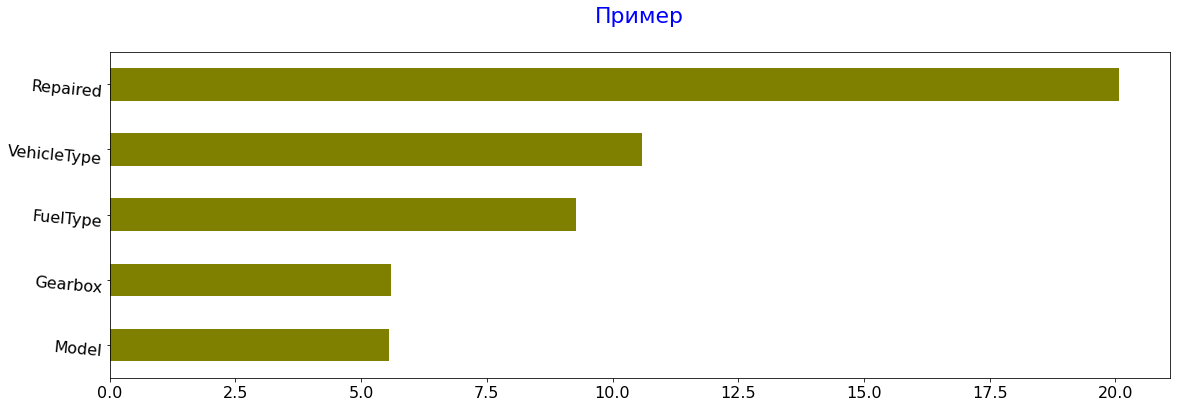

In [8]:
pass_value_barh(df)

In [9]:
df.duplicated().sum()

4

**Вывод**: Файл открыты и изучен,у нас в наличии 16 столбцов, один из них целевой признак *price*.Посмотрел на основную информацию, пропуски в 5 столбцах, типы данных соответствуют данным, есть 4 дубликата,есть ненужные столбцы для работы.

In [10]:
new_columns = []
for col in df.columns:
    new_columns.append(re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower())
df.columns = new_columns
# привел название столбцов в змеиный стиль

In [11]:
for column in df.columns:
    unique_count = df[column].nunique()
    unique_values = df[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)
# посмотрел уникальные значения в столбцах и их количестве

Столбец 'date_crawled' имеет 271174 unique values:
['2016-03-24T11:52:17.000000000' '2016-03-24T10:58:45.000000000'
 '2016-03-14T12:52:21.000000000' ... '2016-03-21T09:50:58.000000000'
 '2016-03-14T17:48:27.000000000' '2016-03-19T18:57:12.000000000']
Столбец 'price' имеет 3731 unique values:
[  480 18300  9800 ... 12395 18429 10985]
Столбец 'vehicle_type' имеет 8 unique values:
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Столбец 'registration_year' имеет 151 unique values:
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 14

In [12]:
df.describe().T
# посмотрел описательную статистику в таблице

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [13]:
df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 
                 'last_seen', 'registration_month', 'date_crawled'], axis=1, inplace=True)
# удалил ненужные для обучения столбцы 

In [14]:
df.duplicated().sum()

13372

In [15]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
# удалил дубликаты и обновил индексы

**Вывод:** Удалил дубликаты,привел название столбцов в змеиный стиль, посмотрел описательную статистику в таблице,удалил ненужные для обучения столбцы 'date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'registration_month', 'date_crawled'.

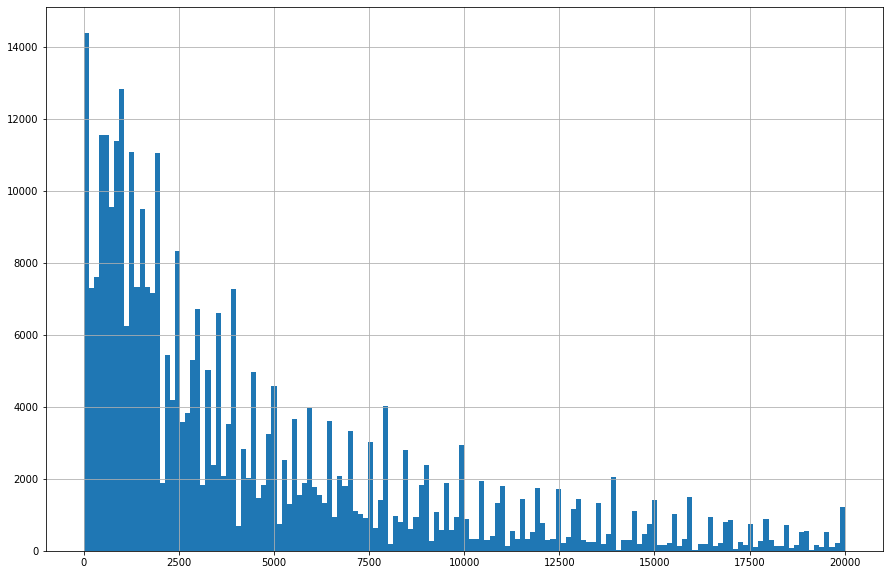

In [16]:
df.price.hist(bins = 150);

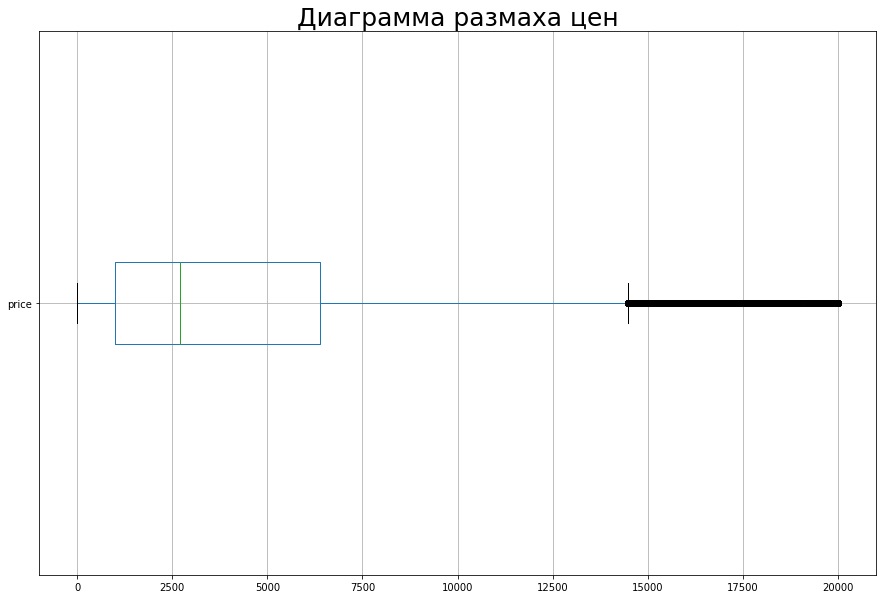

In [17]:
df.boxplot(column=['price'], grid=True, vert=False)
plt.title('Диаграмма размаха цен', size=25);
plt.show()

In [18]:
df.price.quantile([.05, 0.95])
# посмотрел 0,05 и 0,95 квантиль в столбце price

0.05      200.0
0.95    14600.0
Name: price, dtype: float64

In [19]:
1 - df.query('200 <= price <= 14600').shape[0] / len(df)
# посчитал процент тех цен,которые будут удалены

0.09966070082727996

In [20]:
df = df.query('199 < price < 14601')

В целевом признаке присутствуют данные,которые не понадобятся для обучения,это слишком низкая цена до 200 и выбросы более 14600,как ориентир были взяты 0,05 и 0,95 квантиль.

In [21]:
df = df.query('7 < power < 550')
df.loc[df['power'] <= 50, 'power'] = 105
# отфильтровал мощность двигателя и все что ниже 50 прировнял к медианне

Мощность ниже 7 можно не брать в расчет,так как это не корректные данные,так же как и мощность более 550,посмотрев список марок и моделей выше 550,скорее всего это аномалии и выбросы,мощность ниже 50 скорее всего это тоже ошибка,прировнял их к медианне.

In [22]:
df = df.query('1980 <= registration_year <= 2016')
# отфильтровал годы регитраций авто

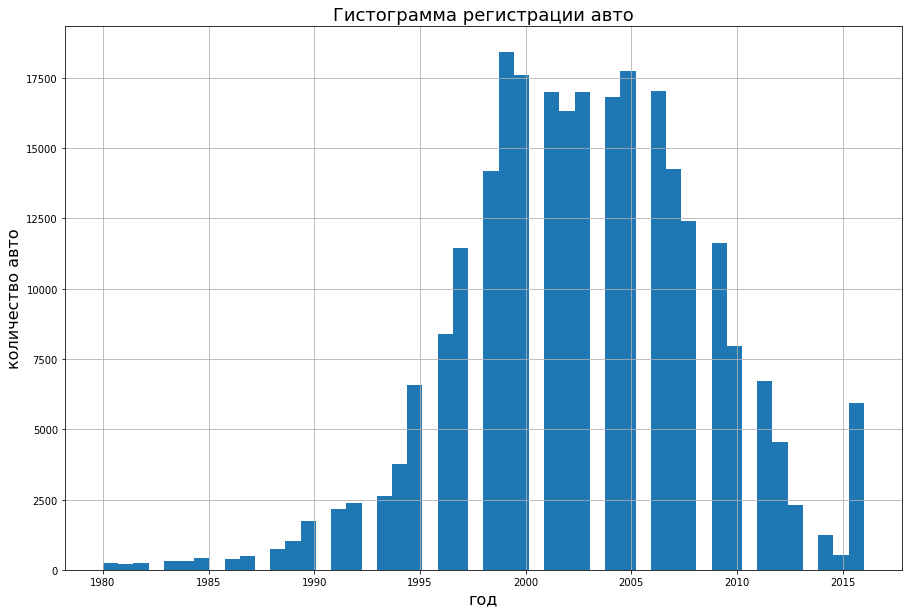

In [23]:
hist = df.registration_year.hist(bins=50) 
  
plt.title('Гистограмма регистрации авто', fontsize=18) 
plt.xlabel('год', fontsize=16) 
plt.ylabel('количество авто', fontsize=16) 
   
plt.show()

Годы регистрации до 1980 считаю не нужные для анализа,их не много и для дальнейшей оценки авто не понадабятся.

In [24]:
df.kilometer.value_counts()
# вывел уникальные значения

150000    180802
125000     28270
100000     10927
90000       8682
80000       7408
70000       6253
60000       5264
50000       4266
40000       3247
30000       2762
5000        2303
20000       2263
10000        562
Name: kilometer, dtype: int64

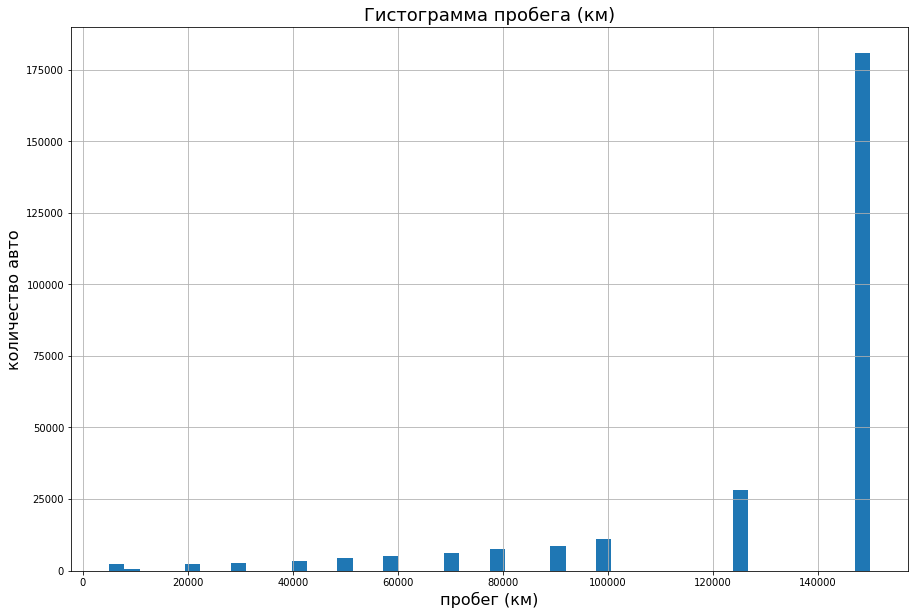

In [25]:
hist = df.kilometer.hist(bins=50) 
  
plt.title('Гистограмма пробега (км)', fontsize=18) 
plt.xlabel('пробег (км)', fontsize=16) 
plt.ylabel('количество авто', fontsize=16) 
   
plt.show()

Вывел уникальные значения столбца с пробегом,данные распределены от 5000 до 150000,больше всего автомобилей с пробегом 150000.

In [26]:
df.brand.value_counts()
# вывел уникальные значения

volkswagen        56811
opel              29746
bmw               27712
mercedes_benz     23461
audi              21683
ford              18614
renault           12986
peugeot            8767
fiat               7036
seat               5351
skoda              4414
mazda              4388
smart              4313
citroen            3949
toyota             3748
nissan             3609
hyundai            2790
volvo              2487
mini               2374
mitsubishi         2316
honda              2232
kia                1851
suzuki             1825
alfa_romeo         1803
chevrolet          1270
sonstige_autos     1131
chrysler           1075
dacia               756
subaru              577
daihatsu            576
jeep                471
saab                430
daewoo              382
porsche             359
jaguar              355
lancia              339
rover               338
land_rover          337
trabant             212
lada                135
Name: brand, dtype: int64

In [27]:
df.gearbox.value_counts()

manual    209696
auto       48489
Name: gearbox, dtype: int64

In [28]:
df['gearbox'] = df['gearbox'].fillna('unknown')

df.reset_index(drop= True , inplace= True)
#заменил пропуски на заглушку и  и обновил индексы

Заменил пропуски в столбце вид коробки передач на заглушку.

In [29]:
df['repaired'].unique()
# вывел уникальные значения

array([nan, 'no', 'yes'], dtype=object)

In [30]:
df['repaired'] = df['repaired'].fillna('unknown')

df.reset_index(drop= True , inplace= True)
#заменил пропуски на заглушку и обновил индексы

Заменил пропуски в столбце *Repaired* на заглушку,скорее всего большинство авто были в ремонте.

In [31]:
df.isna().sum()
# выввел суммму пропусков в каждом столбце

price                    0
vehicle_type         10007
registration_year        0
gearbox                  0
power                    0
model                 9761
kilometer                0
fuel_type            14209
brand                    0
repaired                 0
date_created             0
dtype: int64

In [32]:
df['model'] = df['model'].fillna('unknown')

df.reset_index(drop= True , inplace= True)
#заменил пропуски на заглушку и обновил индексы

Заменил пропуски в столбце *model* на заглушку,пропусков много,при удалении будут большие потери данных.

In [33]:
df['vehicle_type'].unique()
# вывел уникальные значения

array(['suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', nan,
       'coupe', 'other'], dtype=object)

In [34]:
df['vehicle_type'].isnull().sum()
# вывел сумму пропусков в столбце

10007

In [35]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

Заменил пропуски в столбце *vehicle_type* на значение заглушку 'unknown',пропусков много,при удалении будут большие потери данных.

In [36]:
df['fuel_type'].isnull().sum()

14209

In [37]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [38]:
df['fuel_type'] = df['fuel_type']. replace ('gasoline', 'petrol')

In [39]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')

Заменил пропуски в столбце *fuel_type* на значение заглушку 'unknown',пропусков много,при удалении будут большие потери данных.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263009 entries, 0 to 263008
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              263009 non-null  int64         
 1   vehicle_type       263009 non-null  object        
 2   registration_year  263009 non-null  int64         
 3   gearbox            263009 non-null  object        
 4   power              263009 non-null  int64         
 5   model              263009 non-null  object        
 6   kilometer          263009 non-null  int64         
 7   fuel_type          263009 non-null  object        
 8   brand              263009 non-null  object        
 9   repaired           263009 non-null  object        
 10  date_created       263009 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 22.1+ MB


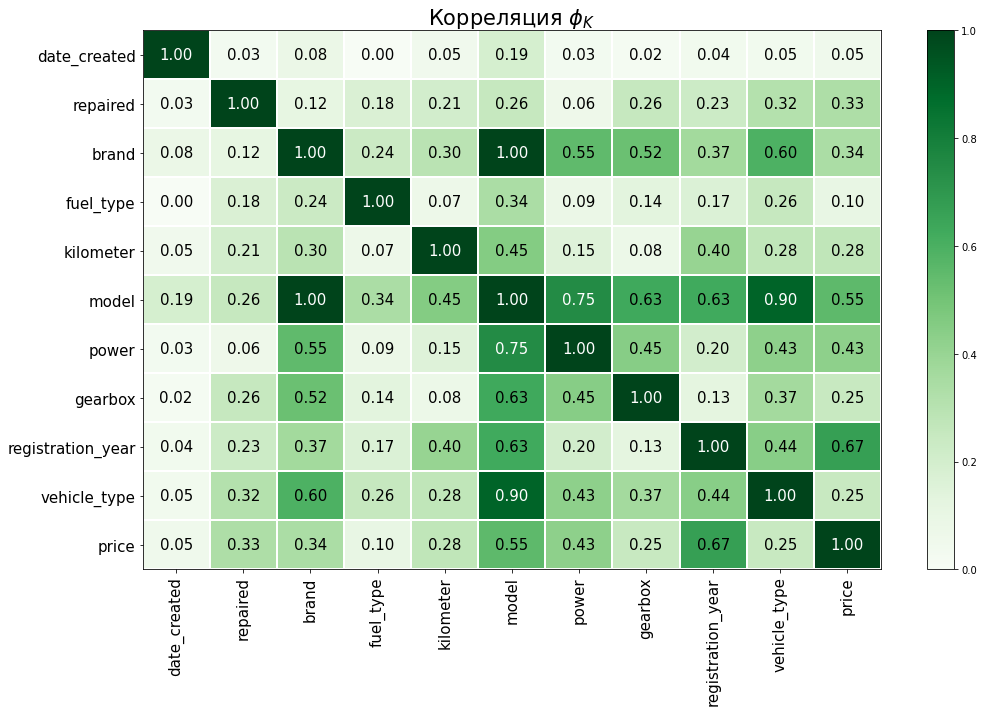

In [41]:
df_phik = df
interval_cols = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']

phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Провел корреляционный анализ, видим зависимость у столбцов и бренд,так же у модели и типа автомобильного кузова,бренда и типа автомобильного кузова,год регистрации автомобиля и цены,моделя и цены,модели с годом регистрации автомобиля и типом коробки передач.

**Выводы:** Провел корреляцианый анализ,наблюдаю сильную зависимость, при разделении df удалю столбец модель. Так же заменил пропуски в столбцах на заглушки,не стал удалять,так как процент пропусков в каждом столбе большой.

## Обучение моделей

In [42]:
features = df.drop(['price', 'brand'], axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [43]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(197256, 9)
(65753, 9)
(197256,)
(65753,)


In [44]:
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'kilometer', 'repaired']

ord_columns = ['model']

num_columns = ['registration_year', 'power']

In [45]:
ohe_encoder = OneHotEncoder(sparse=False, drop='first')
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
ohe_encoder_col_names = ohe_encoder.get_feature_names_out()

ord_encoder = OrdinalEncoder()
X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])
ord_encoder_col_names = ord_encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_encoder_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_total = pd.concat([X_train_ohe, X_train_ord, X_train_scaled], axis=1)

X_test_total = pd.concat([X_test_ohe, X_test_ord, X_test_scaled], axis=1)

In [46]:
for i in [X_train_total, X_test_total, y_train, y_test]:
    print(i.shape)

(197256, 33)
(65753, 33)
(197256,)
(65753,)


Разделил данные на тестовые и тренировочные, подготовил данные для кодировки и стандартизации,проверил разделении,все соответствует.

### Обучение LinearRegression

In [47]:
import time


In [48]:
start = time.time()

model_lr = LinearRegression() 
score_lr = cross_val_score(model_lr, X_train_total, y_train, scoring='neg_mean_squared_error', cv=5)
score_lr = round(np.mean(-score_lr)**0.5, 2)
print(f"Среднее значение RMSE: {score_lr:.2f}")

lr_search_time = time.time() - start
print(f'Search time:{round(lr_search_time, 2)}')

Среднее значение RMSE: 2208.98
Search time:5.57


In [49]:
%%time
 
model_lr.fit(X_train_total, y_train)

CPU times: user 694 ms, sys: 393 ms, total: 1.09 s
Wall time: 1.09 s


LinearRegression()

In [50]:
%%time

predict_lr = model_lr.predict(X_train_total)

CPU times: user 33.5 ms, sys: 25 ms, total: 58.5 ms
Wall time: 85.3 ms


Обучил линейную регрессию на закодированных данных,вывел время на данные операции и cреднее значение RMSE: 2208.98

### Обучение  CatBoostRegressor

In [51]:
start = time.time()

model_cbr = CatBoostRegressor(loss_function='RMSE', random_state=RANDOM_STATE, learning_rate=.5, iterations=50, 
                              cat_features=['vehicle_type', 'fuel_type', 'model', 'gearbox', 'kilometer', 'repaired']) 
score_cbr = cross_val_score(model_cbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
score_cbr = round(np.mean(-score_cbr)**0.5, 2)
print(f"Среднее значение RMSE: {score_cbr:.2f}")

cbr_search_time = time.time() - start
print(f'Search time:{round(cbr_search_time, 2)}')

0:	learn: 2568.5955162	total: 137ms	remaining: 6.69s
1:	learn: 2088.7456887	total: 235ms	remaining: 5.64s
2:	learn: 1895.5430903	total: 314ms	remaining: 4.92s
3:	learn: 1780.1383235	total: 372ms	remaining: 4.28s
4:	learn: 1714.7093042	total: 428ms	remaining: 3.85s
5:	learn: 1679.2629425	total: 486ms	remaining: 3.56s
6:	learn: 1659.1581500	total: 545ms	remaining: 3.35s
7:	learn: 1622.0390974	total: 605ms	remaining: 3.17s
8:	learn: 1603.1711348	total: 668ms	remaining: 3.04s
9:	learn: 1588.8072607	total: 735ms	remaining: 2.94s
10:	learn: 1577.3456269	total: 814ms	remaining: 2.88s
11:	learn: 1567.6339269	total: 876ms	remaining: 2.77s
12:	learn: 1558.2974633	total: 944ms	remaining: 2.69s
13:	learn: 1549.3556106	total: 1s	remaining: 2.58s
14:	learn: 1540.0810444	total: 1.07s	remaining: 2.49s
15:	learn: 1533.4293805	total: 1.14s	remaining: 2.42s
16:	learn: 1527.9417388	total: 1.22s	remaining: 2.36s
17:	learn: 1523.4047296	total: 1.27s	remaining: 2.26s
18:	learn: 1517.8089332	total: 1.33s	rema

4:	learn: 1717.6872630	total: 332ms	remaining: 2.99s
5:	learn: 1687.7831354	total: 391ms	remaining: 2.87s
6:	learn: 1640.5384085	total: 448ms	remaining: 2.75s
7:	learn: 1614.6101181	total: 514ms	remaining: 2.7s
8:	learn: 1594.4069477	total: 573ms	remaining: 2.61s
9:	learn: 1582.5362738	total: 645ms	remaining: 2.58s
10:	learn: 1570.5891974	total: 729ms	remaining: 2.58s
11:	learn: 1560.4678718	total: 794ms	remaining: 2.52s
12:	learn: 1553.4392240	total: 875ms	remaining: 2.49s
13:	learn: 1542.3922608	total: 950ms	remaining: 2.44s
14:	learn: 1535.6455791	total: 1.01s	remaining: 2.36s
15:	learn: 1526.2421387	total: 1.07s	remaining: 2.27s
16:	learn: 1522.6370112	total: 1.14s	remaining: 2.21s
17:	learn: 1519.1346451	total: 1.2s	remaining: 2.13s
18:	learn: 1515.5380783	total: 1.26s	remaining: 2.05s
19:	learn: 1511.9698494	total: 1.32s	remaining: 1.98s
20:	learn: 1504.0261080	total: 1.38s	remaining: 1.9s
21:	learn: 1500.7751732	total: 1.44s	remaining: 1.83s
22:	learn: 1497.3614858	total: 1.5s	r

In [52]:
%%time

model_cbr.fit(X_train, y_train) 

0:	learn: 2584.6251760	total: 95.4ms	remaining: 4.67s
1:	learn: 2136.1111894	total: 187ms	remaining: 4.49s
2:	learn: 1904.7824240	total: 281ms	remaining: 4.4s
3:	learn: 1770.8153529	total: 362ms	remaining: 4.17s
4:	learn: 1706.7649026	total: 439ms	remaining: 3.95s
5:	learn: 1676.1761354	total: 514ms	remaining: 3.77s
6:	learn: 1653.1271809	total: 587ms	remaining: 3.61s
7:	learn: 1614.1600225	total: 661ms	remaining: 3.47s
8:	learn: 1597.8452067	total: 740ms	remaining: 3.37s
9:	learn: 1586.9862013	total: 815ms	remaining: 3.26s
10:	learn: 1577.2115124	total: 893ms	remaining: 3.17s
11:	learn: 1564.3252402	total: 969ms	remaining: 3.07s
12:	learn: 1554.9624360	total: 1.05s	remaining: 2.98s
13:	learn: 1545.9497254	total: 1.12s	remaining: 2.89s
14:	learn: 1539.8828585	total: 1.21s	remaining: 2.82s
15:	learn: 1534.0796962	total: 1.28s	remaining: 2.73s
16:	learn: 1523.4763330	total: 1.38s	remaining: 2.68s
17:	learn: 1517.7562017	total: 1.47s	remaining: 2.61s
18:	learn: 1515.2616442	total: 1.54s	r

In [53]:
%%time

predict_cbr = model_cbr.predict(X_train)

CPU times: user 326 ms, sys: 11.6 ms, total: 338 ms
Wall time: 337 ms


Обучил CatBoostRegressor,вывел время на данные операции и среднее значение RMSE: 1449.44

### обучение CatBoostRegressor GridSearchCV

In [54]:
start = time.time()

model_cbr_gs = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid_cbr = GridSearchCV(estimator=model_cbr_gs, param_grid = parameters, cv = 5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cbr.fit(X_train_total, y_train)

gs_search_time = time.time() - start
print(f'Search time:{gs_search_time}')

0:	learn: 3544.6209765	total: 23ms	remaining: 666ms
1:	learn: 3521.7832050	total: 45.5ms	remaining: 638ms
2:	learn: 3499.5848716	total: 67.1ms	remaining: 604ms
3:	learn: 3477.3192672	total: 87.8ms	remaining: 571ms
4:	learn: 3455.5678060	total: 109ms	remaining: 545ms
5:	learn: 3434.2583168	total: 130ms	remaining: 521ms
6:	learn: 3412.8128401	total: 152ms	remaining: 499ms
7:	learn: 3392.0070397	total: 175ms	remaining: 481ms
8:	learn: 3371.4921136	total: 198ms	remaining: 462ms
9:	learn: 3351.0959766	total: 221ms	remaining: 442ms
10:	learn: 3331.2234335	total: 248ms	remaining: 428ms
11:	learn: 3310.6473338	total: 271ms	remaining: 406ms
12:	learn: 3290.3859076	total: 293ms	remaining: 383ms
13:	learn: 3270.8419076	total: 315ms	remaining: 360ms
14:	learn: 3251.4708529	total: 338ms	remaining: 338ms
15:	learn: 3231.9267823	total: 360ms	remaining: 315ms
16:	learn: 3213.4968680	total: 383ms	remaining: 293ms
17:	learn: 3194.9667244	total: 414ms	remaining: 276ms
18:	learn: 3176.3479736	total: 436ms

9:	learn: 2691.7380079	total: 223ms	remaining: 445ms
10:	learn: 2632.2572171	total: 245ms	remaining: 424ms
11:	learn: 2573.8486963	total: 267ms	remaining: 401ms
12:	learn: 2518.9843712	total: 289ms	remaining: 378ms
13:	learn: 2469.6266013	total: 311ms	remaining: 355ms
14:	learn: 2421.8144561	total: 332ms	remaining: 332ms
15:	learn: 2378.0837476	total: 354ms	remaining: 310ms
16:	learn: 2338.3525777	total: 378ms	remaining: 289ms
17:	learn: 2300.8692849	total: 405ms	remaining: 270ms
18:	learn: 2262.9888921	total: 428ms	remaining: 248ms
19:	learn: 2228.3730399	total: 450ms	remaining: 225ms
20:	learn: 2198.0488591	total: 476ms	remaining: 204ms
21:	learn: 2169.3013355	total: 499ms	remaining: 182ms
22:	learn: 2140.9105311	total: 521ms	remaining: 159ms
23:	learn: 2116.5855442	total: 543ms	remaining: 136ms
24:	learn: 2091.5856458	total: 570ms	remaining: 114ms
25:	learn: 2068.5544734	total: 592ms	remaining: 91.1ms
26:	learn: 2047.3615413	total: 614ms	remaining: 68.2ms
27:	learn: 2027.8502919	tot

18:	learn: 1874.6251213	total: 451ms	remaining: 261ms
19:	learn: 1855.3225846	total: 473ms	remaining: 237ms
20:	learn: 1839.3494208	total: 494ms	remaining: 212ms
21:	learn: 1824.2958943	total: 514ms	remaining: 187ms
22:	learn: 1811.0220448	total: 536ms	remaining: 163ms
23:	learn: 1800.6586209	total: 561ms	remaining: 140ms
24:	learn: 1790.0739705	total: 581ms	remaining: 116ms
25:	learn: 1778.9334584	total: 600ms	remaining: 92.3ms
26:	learn: 1769.8540228	total: 619ms	remaining: 68.8ms
27:	learn: 1761.3936738	total: 640ms	remaining: 45.7ms
28:	learn: 1753.7590869	total: 662ms	remaining: 22.8ms
29:	learn: 1745.2689580	total: 684ms	remaining: 0us
0:	learn: 3344.2121310	total: 30.7ms	remaining: 891ms
1:	learn: 3144.7859736	total: 52ms	remaining: 728ms
2:	learn: 2972.3125461	total: 73.1ms	remaining: 658ms
3:	learn: 2820.4504822	total: 95.6ms	remaining: 622ms
4:	learn: 2689.7721914	total: 117ms	remaining: 584ms
5:	learn: 2566.3909699	total: 138ms	remaining: 550ms
6:	learn: 2462.9097510	total: 

26:	learn: 3037.6368964	total: 633ms	remaining: 539ms
27:	learn: 3021.0203311	total: 654ms	remaining: 514ms
28:	learn: 3004.9207527	total: 676ms	remaining: 489ms
29:	learn: 2988.9735663	total: 702ms	remaining: 468ms
30:	learn: 2973.1325733	total: 723ms	remaining: 443ms
31:	learn: 2957.6084127	total: 744ms	remaining: 419ms
32:	learn: 2941.8455828	total: 765ms	remaining: 394ms
33:	learn: 2926.3073295	total: 789ms	remaining: 371ms
34:	learn: 2911.3736366	total: 812ms	remaining: 348ms
35:	learn: 2896.1111062	total: 834ms	remaining: 324ms
36:	learn: 2881.0779760	total: 854ms	remaining: 300ms
37:	learn: 2866.5505621	total: 876ms	remaining: 277ms
38:	learn: 2852.2480146	total: 901ms	remaining: 254ms
39:	learn: 2838.0183593	total: 922ms	remaining: 231ms
40:	learn: 2823.8341203	total: 943ms	remaining: 207ms
41:	learn: 2809.8094374	total: 964ms	remaining: 184ms
42:	learn: 2796.1695702	total: 991ms	remaining: 161ms
43:	learn: 2782.4553283	total: 1.01s	remaining: 138ms
44:	learn: 2769.0645435	tota

37:	learn: 2864.9601266	total: 848ms	remaining: 268ms
38:	learn: 2850.6471592	total: 871ms	remaining: 246ms
39:	learn: 2836.5611117	total: 897ms	remaining: 224ms
40:	learn: 2822.4065595	total: 920ms	remaining: 202ms
41:	learn: 2808.4590588	total: 943ms	remaining: 180ms
42:	learn: 2794.8066147	total: 965ms	remaining: 157ms
43:	learn: 2781.2130776	total: 987ms	remaining: 135ms
44:	learn: 2767.7231510	total: 1.01s	remaining: 112ms
45:	learn: 2754.2288093	total: 1.03s	remaining: 89.5ms
46:	learn: 2741.1222884	total: 1.05s	remaining: 67.1ms
47:	learn: 2728.2871543	total: 1.07s	remaining: 44.7ms
48:	learn: 2715.3936137	total: 1.1s	remaining: 22.4ms
49:	learn: 2702.9695390	total: 1.12s	remaining: 0us
0:	learn: 3551.1401178	total: 29.7ms	remaining: 1.46s
1:	learn: 3528.5506364	total: 52ms	remaining: 1.25s
2:	learn: 3506.5218296	total: 75.3ms	remaining: 1.18s
3:	learn: 3484.3887670	total: 98ms	remaining: 1.13s
4:	learn: 3462.8341182	total: 134ms	remaining: 1.21s
5:	learn: 3441.1217988	total: 17

44:	learn: 1829.0521056	total: 1.04s	remaining: 115ms
45:	learn: 1822.2974775	total: 1.06s	remaining: 92.1ms
46:	learn: 1815.9587178	total: 1.08s	remaining: 69.2ms
47:	learn: 1810.0259085	total: 1.1s	remaining: 46ms
48:	learn: 1804.7161647	total: 1.12s	remaining: 22.9ms
49:	learn: 1798.9439706	total: 1.14s	remaining: 0us
0:	learn: 3455.0994567	total: 23.8ms	remaining: 1.17s
1:	learn: 3347.4236467	total: 46.5ms	remaining: 1.12s
2:	learn: 3248.8193223	total: 68.6ms	remaining: 1.07s
3:	learn: 3155.4728480	total: 90.5ms	remaining: 1.04s
4:	learn: 3063.0169821	total: 112ms	remaining: 1.01s
5:	learn: 2976.7562035	total: 133ms	remaining: 978ms
6:	learn: 2899.2424058	total: 155ms	remaining: 953ms
7:	learn: 2825.4617963	total: 178ms	remaining: 933ms
8:	learn: 2756.2926453	total: 201ms	remaining: 914ms
9:	learn: 2690.9591516	total: 223ms	remaining: 890ms
10:	learn: 2630.1557163	total: 244ms	remaining: 867ms
11:	learn: 2571.1818599	total: 266ms	remaining: 844ms
12:	learn: 2516.6023033	total: 291m

0:	learn: 3344.8277864	total: 21.2ms	remaining: 1.04s
1:	learn: 3144.6194322	total: 43.3ms	remaining: 1.04s
2:	learn: 2972.0913342	total: 66.6ms	remaining: 1.04s
3:	learn: 2813.3808978	total: 89.1ms	remaining: 1.02s
4:	learn: 2679.1440923	total: 111ms	remaining: 1s
5:	learn: 2560.2436418	total: 133ms	remaining: 974ms
6:	learn: 2459.6617487	total: 154ms	remaining: 947ms
7:	learn: 2371.9344435	total: 177ms	remaining: 928ms
8:	learn: 2296.5432365	total: 199ms	remaining: 908ms
9:	learn: 2222.1184901	total: 222ms	remaining: 889ms
10:	learn: 2157.1720260	total: 246ms	remaining: 871ms
11:	learn: 2101.0789956	total: 269ms	remaining: 851ms
12:	learn: 2054.1594134	total: 292ms	remaining: 830ms
13:	learn: 2013.5349199	total: 314ms	remaining: 807ms
14:	learn: 1978.7854673	total: 335ms	remaining: 781ms
15:	learn: 1947.0204336	total: 358ms	remaining: 760ms
16:	learn: 1920.9862463	total: 381ms	remaining: 739ms
17:	learn: 1895.8753679	total: 403ms	remaining: 716ms
18:	learn: 1874.6251213	total: 423ms	

8:	learn: 2288.7398290	total: 238ms	remaining: 1.08s
9:	learn: 2217.5108815	total: 260ms	remaining: 1.04s
10:	learn: 2159.4967995	total: 283ms	remaining: 1s
11:	learn: 2104.2364238	total: 309ms	remaining: 980ms
12:	learn: 2056.2729015	total: 332ms	remaining: 946ms
13:	learn: 2012.9603996	total: 354ms	remaining: 910ms
14:	learn: 1979.6657037	total: 377ms	remaining: 879ms
15:	learn: 1949.4484009	total: 399ms	remaining: 848ms
16:	learn: 1921.3359973	total: 422ms	remaining: 819ms
17:	learn: 1896.3671529	total: 443ms	remaining: 788ms
18:	learn: 1876.0967066	total: 467ms	remaining: 763ms
19:	learn: 1858.7761486	total: 488ms	remaining: 733ms
20:	learn: 1840.2923121	total: 513ms	remaining: 709ms
21:	learn: 1826.1301314	total: 534ms	remaining: 680ms
22:	learn: 1812.1615041	total: 556ms	remaining: 653ms
23:	learn: 1799.9197973	total: 577ms	remaining: 625ms
24:	learn: 1789.4731139	total: 598ms	remaining: 598ms
25:	learn: 1780.2439904	total: 618ms	remaining: 571ms
26:	learn: 1769.0282617	total: 64

61:	learn: 2565.0076073	total: 1.48s	remaining: 907ms
62:	learn: 2554.4727347	total: 1.5s	remaining: 884ms
63:	learn: 2543.9281649	total: 1.53s	remaining: 859ms
64:	learn: 2533.4126886	total: 1.55s	remaining: 835ms
65:	learn: 2523.0129696	total: 1.57s	remaining: 810ms
66:	learn: 2512.9132570	total: 1.6s	remaining: 786ms
67:	learn: 2503.0278022	total: 1.62s	remaining: 762ms
68:	learn: 2492.8816435	total: 1.64s	remaining: 738ms
69:	learn: 2482.7878407	total: 1.66s	remaining: 713ms
70:	learn: 2473.4134836	total: 1.69s	remaining: 688ms
71:	learn: 2463.8468841	total: 1.71s	remaining: 664ms
72:	learn: 2454.8373223	total: 1.73s	remaining: 640ms
73:	learn: 2445.6292209	total: 1.75s	remaining: 616ms
74:	learn: 2436.5940744	total: 1.78s	remaining: 592ms
75:	learn: 2427.5419749	total: 1.8s	remaining: 568ms
76:	learn: 2418.3910077	total: 1.82s	remaining: 544ms
77:	learn: 2409.4631568	total: 1.84s	remaining: 519ms
78:	learn: 2400.9587748	total: 1.86s	remaining: 495ms
79:	learn: 2392.0849327	total: 

18:	learn: 3177.2923716	total: 439ms	remaining: 1.87s
19:	learn: 3158.7758852	total: 463ms	remaining: 1.85s
20:	learn: 3140.6232161	total: 484ms	remaining: 1.82s
21:	learn: 3122.7462607	total: 506ms	remaining: 1.79s
22:	learn: 3105.3065087	total: 528ms	remaining: 1.77s
23:	learn: 3088.1376664	total: 549ms	remaining: 1.74s
24:	learn: 3070.6171934	total: 571ms	remaining: 1.71s
25:	learn: 3054.0085618	total: 593ms	remaining: 1.69s
26:	learn: 3036.8330525	total: 615ms	remaining: 1.66s
27:	learn: 3020.2343829	total: 640ms	remaining: 1.64s
28:	learn: 3004.1673701	total: 666ms	remaining: 1.63s
29:	learn: 2988.1841123	total: 689ms	remaining: 1.61s
30:	learn: 2972.3459382	total: 717ms	remaining: 1.6s
31:	learn: 2956.9636566	total: 751ms	remaining: 1.59s
32:	learn: 2941.2792011	total: 775ms	remaining: 1.57s
33:	learn: 2925.7650508	total: 800ms	remaining: 1.55s
34:	learn: 2910.7079990	total: 822ms	remaining: 1.53s
35:	learn: 2895.4438997	total: 844ms	remaining: 1.5s
36:	learn: 2880.6120123	total:

79:	learn: 2391.0378331	total: 1.87s	remaining: 468ms
80:	learn: 2382.6655548	total: 1.89s	remaining: 444ms
81:	learn: 2374.4264302	total: 1.92s	remaining: 421ms
82:	learn: 2366.4281503	total: 1.94s	remaining: 397ms
83:	learn: 2357.9522524	total: 1.96s	remaining: 373ms
84:	learn: 2349.8881455	total: 1.98s	remaining: 349ms
85:	learn: 2342.0968186	total: 2.01s	remaining: 327ms
86:	learn: 2334.1178238	total: 2.03s	remaining: 303ms
87:	learn: 2326.4000084	total: 2.05s	remaining: 280ms
88:	learn: 2318.5924809	total: 2.07s	remaining: 256ms
89:	learn: 2311.0150714	total: 2.1s	remaining: 233ms
90:	learn: 2303.6602696	total: 2.12s	remaining: 210ms
91:	learn: 2296.2266041	total: 2.14s	remaining: 186ms
92:	learn: 2289.1545693	total: 2.17s	remaining: 163ms
93:	learn: 2281.8702569	total: 2.19s	remaining: 140ms
94:	learn: 2274.8926937	total: 2.22s	remaining: 117ms
95:	learn: 2267.8130681	total: 2.24s	remaining: 93.2ms
96:	learn: 2260.8109890	total: 2.26s	remaining: 69.8ms
97:	learn: 2254.1432722	tot

36:	learn: 1894.1102509	total: 872ms	remaining: 1.48s
37:	learn: 1883.9292302	total: 894ms	remaining: 1.46s
38:	learn: 1874.0619976	total: 915ms	remaining: 1.43s
39:	learn: 1864.9802214	total: 937ms	remaining: 1.41s
40:	learn: 1855.7167192	total: 958ms	remaining: 1.38s
41:	learn: 1847.3338005	total: 980ms	remaining: 1.35s
42:	learn: 1839.4930238	total: 1s	remaining: 1.33s
43:	learn: 1832.0693302	total: 1.02s	remaining: 1.3s
44:	learn: 1825.1604524	total: 1.05s	remaining: 1.28s
45:	learn: 1818.4356896	total: 1.07s	remaining: 1.25s
46:	learn: 1812.2144708	total: 1.09s	remaining: 1.23s
47:	learn: 1806.4144560	total: 1.11s	remaining: 1.21s
48:	learn: 1800.1056508	total: 1.13s	remaining: 1.18s
49:	learn: 1793.3809619	total: 1.16s	remaining: 1.16s
50:	learn: 1788.0396873	total: 1.18s	remaining: 1.13s
51:	learn: 1782.1205148	total: 1.2s	remaining: 1.11s
52:	learn: 1777.3393434	total: 1.22s	remaining: 1.08s
53:	learn: 1772.4422192	total: 1.25s	remaining: 1.06s
54:	learn: 1767.1455626	total: 1.

92:	learn: 1661.5385882	total: 2.11s	remaining: 159ms
93:	learn: 1659.2676230	total: 2.13s	remaining: 136ms
94:	learn: 1658.0321239	total: 2.15s	remaining: 113ms
95:	learn: 1656.1574706	total: 2.17s	remaining: 90.6ms
96:	learn: 1654.8400430	total: 2.19s	remaining: 67.8ms
97:	learn: 1653.2392426	total: 2.21s	remaining: 45.2ms
98:	learn: 1651.4560102	total: 2.23s	remaining: 22.6ms
99:	learn: 1649.9477218	total: 2.26s	remaining: 0us
0:	learn: 3455.0994567	total: 32ms	remaining: 3.16s
1:	learn: 3347.4236467	total: 54.9ms	remaining: 2.69s
2:	learn: 3248.8193223	total: 76.5ms	remaining: 2.47s
3:	learn: 3155.4728480	total: 98.4ms	remaining: 2.36s
4:	learn: 3063.0169821	total: 122ms	remaining: 2.31s
5:	learn: 2976.7562035	total: 143ms	remaining: 2.24s
6:	learn: 2899.2424058	total: 164ms	remaining: 2.18s
7:	learn: 2825.4617963	total: 187ms	remaining: 2.15s
8:	learn: 2756.2926453	total: 210ms	remaining: 2.12s
9:	learn: 2690.9591516	total: 233ms	remaining: 2.1s
10:	learn: 2630.1557163	total: 254m

45:	learn: 1817.8126041	total: 1.05s	remaining: 1.24s
46:	learn: 1811.8106595	total: 1.07s	remaining: 1.21s
47:	learn: 1805.6260506	total: 1.09s	remaining: 1.19s
48:	learn: 1799.6402238	total: 1.12s	remaining: 1.16s
49:	learn: 1794.5838703	total: 1.14s	remaining: 1.14s
50:	learn: 1788.9858900	total: 1.16s	remaining: 1.11s
51:	learn: 1783.9635396	total: 1.18s	remaining: 1.09s
52:	learn: 1779.4068527	total: 1.2s	remaining: 1.06s
53:	learn: 1774.3410757	total: 1.23s	remaining: 1.04s
54:	learn: 1768.4680018	total: 1.25s	remaining: 1.02s
55:	learn: 1764.4778434	total: 1.27s	remaining: 997ms
56:	learn: 1758.8250869	total: 1.29s	remaining: 972ms
57:	learn: 1754.6978704	total: 1.31s	remaining: 949ms
58:	learn: 1749.7728833	total: 1.33s	remaining: 926ms
59:	learn: 1746.4769488	total: 1.35s	remaining: 901ms
60:	learn: 1742.6549372	total: 1.37s	remaining: 878ms
61:	learn: 1739.5534453	total: 1.39s	remaining: 854ms
62:	learn: 1736.3203222	total: 1.42s	remaining: 834ms
63:	learn: 1733.1472675	total

0:	learn: 3344.8277864	total: 25ms	remaining: 2.47s
1:	learn: 3144.6194322	total: 54.7ms	remaining: 2.68s
2:	learn: 2972.0913342	total: 77.8ms	remaining: 2.51s
3:	learn: 2813.3808978	total: 101ms	remaining: 2.42s
4:	learn: 2679.1440923	total: 123ms	remaining: 2.34s
5:	learn: 2560.2436418	total: 149ms	remaining: 2.34s
6:	learn: 2459.6617487	total: 171ms	remaining: 2.28s
7:	learn: 2371.9344435	total: 193ms	remaining: 2.22s
8:	learn: 2296.5432365	total: 216ms	remaining: 2.18s
9:	learn: 2222.1184901	total: 237ms	remaining: 2.13s
10:	learn: 2157.1720260	total: 263ms	remaining: 2.12s
11:	learn: 2101.0789956	total: 284ms	remaining: 2.08s
12:	learn: 2054.1594134	total: 306ms	remaining: 2.05s
13:	learn: 2013.5349199	total: 330ms	remaining: 2.02s
14:	learn: 1978.7854673	total: 351ms	remaining: 1.99s
15:	learn: 1947.0204336	total: 372ms	remaining: 1.95s
16:	learn: 1920.9862463	total: 395ms	remaining: 1.93s
17:	learn: 1895.8753679	total: 417ms	remaining: 1.9s
18:	learn: 1874.6251213	total: 438ms	r

56:	learn: 1630.0259575	total: 1.27s	remaining: 961ms
57:	learn: 1627.5135123	total: 1.29s	remaining: 938ms
58:	learn: 1625.3984051	total: 1.32s	remaining: 916ms
59:	learn: 1622.7085219	total: 1.34s	remaining: 894ms
60:	learn: 1620.0395984	total: 1.36s	remaining: 872ms
61:	learn: 1618.6499122	total: 1.38s	remaining: 849ms
62:	learn: 1615.9496143	total: 1.41s	remaining: 827ms
63:	learn: 1613.8580605	total: 1.43s	remaining: 803ms
64:	learn: 1609.0824384	total: 1.45s	remaining: 779ms
65:	learn: 1606.9111159	total: 1.47s	remaining: 757ms
66:	learn: 1604.7019061	total: 1.49s	remaining: 734ms
67:	learn: 1602.8859684	total: 1.51s	remaining: 711ms
68:	learn: 1600.6550724	total: 1.53s	remaining: 688ms
69:	learn: 1599.0663664	total: 1.55s	remaining: 666ms
70:	learn: 1597.9502843	total: 1.57s	remaining: 643ms
71:	learn: 1594.1962358	total: 1.59s	remaining: 620ms
72:	learn: 1592.3935135	total: 1.61s	remaining: 598ms
73:	learn: 1589.4202389	total: 1.63s	remaining: 574ms
74:	learn: 1587.9930943	tota

9:	learn: 2217.5108815	total: 241ms	remaining: 2.17s
10:	learn: 2159.4967995	total: 266ms	remaining: 2.15s
11:	learn: 2104.2364238	total: 288ms	remaining: 2.11s
12:	learn: 2056.2729015	total: 312ms	remaining: 2.09s
13:	learn: 2012.9603996	total: 335ms	remaining: 2.06s
14:	learn: 1979.6657037	total: 356ms	remaining: 2.02s
15:	learn: 1949.4484009	total: 377ms	remaining: 1.98s
16:	learn: 1921.3359973	total: 399ms	remaining: 1.95s
17:	learn: 1896.3671529	total: 420ms	remaining: 1.91s
18:	learn: 1876.0967066	total: 444ms	remaining: 1.89s
19:	learn: 1858.7761486	total: 469ms	remaining: 1.88s
20:	learn: 1840.2923121	total: 491ms	remaining: 1.84s
21:	learn: 1826.1301314	total: 512ms	remaining: 1.81s
22:	learn: 1812.1615041	total: 533ms	remaining: 1.78s
23:	learn: 1799.9197973	total: 554ms	remaining: 1.75s
24:	learn: 1789.4731139	total: 575ms	remaining: 1.73s
25:	learn: 1780.2439904	total: 596ms	remaining: 1.7s
26:	learn: 1769.0282617	total: 617ms	remaining: 1.67s
27:	learn: 1760.1908883	total:

64:	learn: 1610.4979907	total: 1.46s	remaining: 785ms
65:	learn: 1607.7616788	total: 1.48s	remaining: 761ms
66:	learn: 1605.4995563	total: 1.5s	remaining: 742ms
67:	learn: 1604.3336874	total: 1.52s	remaining: 717ms
68:	learn: 1602.3050667	total: 1.54s	remaining: 694ms
69:	learn: 1599.1353088	total: 1.56s	remaining: 670ms
70:	learn: 1596.9268426	total: 1.58s	remaining: 647ms
71:	learn: 1595.0074230	total: 1.61s	remaining: 625ms
72:	learn: 1593.6438084	total: 1.63s	remaining: 602ms
73:	learn: 1592.8452621	total: 1.65s	remaining: 579ms
74:	learn: 1591.1156018	total: 1.67s	remaining: 556ms
75:	learn: 1589.6544600	total: 1.69s	remaining: 535ms
76:	learn: 1587.7148771	total: 1.71s	remaining: 512ms
77:	learn: 1586.3542466	total: 1.74s	remaining: 490ms
78:	learn: 1584.8666031	total: 1.76s	remaining: 467ms
79:	learn: 1582.6326611	total: 1.78s	remaining: 444ms
80:	learn: 1580.0183660	total: 1.8s	remaining: 422ms
81:	learn: 1578.8172335	total: 1.82s	remaining: 400ms
82:	learn: 1576.6308809	total:

0:	learn: 3549.6700914	total: 27ms	remaining: 783ms
1:	learn: 3525.6449731	total: 54.7ms	remaining: 765ms
2:	learn: 3501.9311601	total: 87.6ms	remaining: 788ms
3:	learn: 3478.4844954	total: 122ms	remaining: 791ms
4:	learn: 3455.1043894	total: 150ms	remaining: 748ms
5:	learn: 3432.0920547	total: 178ms	remaining: 712ms
6:	learn: 3409.5309766	total: 224ms	remaining: 736ms
7:	learn: 3387.4055867	total: 252ms	remaining: 692ms
8:	learn: 3365.4172699	total: 279ms	remaining: 652ms
9:	learn: 3343.4354107	total: 307ms	remaining: 615ms
10:	learn: 3321.7734813	total: 336ms	remaining: 580ms
11:	learn: 3300.5473263	total: 364ms	remaining: 546ms
12:	learn: 3279.6804314	total: 392ms	remaining: 513ms
13:	learn: 3259.1104696	total: 419ms	remaining: 479ms
14:	learn: 3238.7869027	total: 446ms	remaining: 446ms
15:	learn: 3218.7895557	total: 473ms	remaining: 414ms
16:	learn: 3198.6787992	total: 500ms	remaining: 382ms
17:	learn: 3178.6603545	total: 528ms	remaining: 352ms
18:	learn: 3159.1388434	total: 554ms	

8:	learn: 2713.4310244	total: 247ms	remaining: 576ms
9:	learn: 2644.7273733	total: 272ms	remaining: 544ms
10:	learn: 2579.3700150	total: 304ms	remaining: 525ms
11:	learn: 2519.8319430	total: 333ms	remaining: 499ms
12:	learn: 2464.1687892	total: 359ms	remaining: 469ms
13:	learn: 2410.9700247	total: 388ms	remaining: 443ms
14:	learn: 2362.0605738	total: 423ms	remaining: 423ms
15:	learn: 2317.3384262	total: 452ms	remaining: 396ms
16:	learn: 2274.4867990	total: 478ms	remaining: 365ms
17:	learn: 2234.7430580	total: 508ms	remaining: 339ms
18:	learn: 2198.0621347	total: 542ms	remaining: 314ms
19:	learn: 2163.4762058	total: 569ms	remaining: 284ms
20:	learn: 2131.5828102	total: 594ms	remaining: 255ms
21:	learn: 2101.8519888	total: 621ms	remaining: 226ms
22:	learn: 2074.2902600	total: 647ms	remaining: 197ms
23:	learn: 2047.9393041	total: 673ms	remaining: 168ms
24:	learn: 2024.6221646	total: 702ms	remaining: 140ms
25:	learn: 2003.0446733	total: 730ms	remaining: 112ms
26:	learn: 1982.7476727	total:

16:	learn: 1857.6885197	total: 439ms	remaining: 336ms
17:	learn: 1836.2425389	total: 470ms	remaining: 314ms
18:	learn: 1817.0589834	total: 496ms	remaining: 287ms
19:	learn: 1798.0429543	total: 524ms	remaining: 262ms
20:	learn: 1778.2460485	total: 550ms	remaining: 236ms
21:	learn: 1763.6225281	total: 575ms	remaining: 209ms
22:	learn: 1751.9470206	total: 600ms	remaining: 183ms
23:	learn: 1741.0408067	total: 626ms	remaining: 157ms
24:	learn: 1729.6092740	total: 656ms	remaining: 131ms
25:	learn: 1720.9925462	total: 682ms	remaining: 105ms
26:	learn: 1712.1488866	total: 708ms	remaining: 78.6ms
27:	learn: 1703.1089836	total: 736ms	remaining: 52.6ms
28:	learn: 1694.4505034	total: 761ms	remaining: 26.2ms
29:	learn: 1688.9097280	total: 784ms	remaining: 0us
0:	learn: 3543.1591782	total: 24.7ms	remaining: 1.21s
1:	learn: 3519.1713596	total: 50.3ms	remaining: 1.21s
2:	learn: 3495.5063567	total: 76.8ms	remaining: 1.2s
3:	learn: 3472.1711169	total: 101ms	remaining: 1.16s
4:	learn: 3448.8574333	total:

44:	learn: 2721.9063619	total: 1.28s	remaining: 142ms
45:	learn: 2707.7914582	total: 1.31s	remaining: 114ms
46:	learn: 2693.9297921	total: 1.33s	remaining: 85.1ms
47:	learn: 2680.1333391	total: 1.36s	remaining: 56.7ms
48:	learn: 2666.7914561	total: 1.39s	remaining: 28.3ms
49:	learn: 2653.7674903	total: 1.41s	remaining: 0us
0:	learn: 3542.4267660	total: 26.3ms	remaining: 1.29s
1:	learn: 3518.4547169	total: 54.5ms	remaining: 1.31s
2:	learn: 3494.7386300	total: 82.3ms	remaining: 1.29s
3:	learn: 3471.3516172	total: 111ms	remaining: 1.28s
4:	learn: 3448.1067374	total: 139ms	remaining: 1.25s
5:	learn: 3425.2454915	total: 167ms	remaining: 1.22s
6:	learn: 3402.5161034	total: 194ms	remaining: 1.19s
7:	learn: 3380.4713898	total: 220ms	remaining: 1.15s
8:	learn: 3358.5174645	total: 247ms	remaining: 1.13s
9:	learn: 3336.6862095	total: 274ms	remaining: 1.1s
10:	learn: 3315.0655185	total: 316ms	remaining: 1.12s
11:	learn: 3293.7517521	total: 348ms	remaining: 1.1s
12:	learn: 3272.8786686	total: 377ms

0:	learn: 3448.5851888	total: 28ms	remaining: 1.37s
1:	learn: 3335.3492398	total: 55.8ms	remaining: 1.34s
2:	learn: 3229.3692692	total: 82.8ms	remaining: 1.3s
3:	learn: 3128.7325572	total: 109ms	remaining: 1.26s
4:	learn: 3031.8076361	total: 136ms	remaining: 1.23s
5:	learn: 2943.4631634	total: 163ms	remaining: 1.19s
6:	learn: 2861.6006050	total: 189ms	remaining: 1.16s
7:	learn: 2783.2746526	total: 216ms	remaining: 1.13s
8:	learn: 2711.2243460	total: 249ms	remaining: 1.13s
9:	learn: 2642.0355593	total: 289ms	remaining: 1.15s
10:	learn: 2577.4278532	total: 317ms	remaining: 1.13s
11:	learn: 2518.4842685	total: 343ms	remaining: 1.09s
12:	learn: 2463.2228993	total: 370ms	remaining: 1.05s
13:	learn: 2411.3686463	total: 400ms	remaining: 1.03s
14:	learn: 2362.6198136	total: 426ms	remaining: 993ms
15:	learn: 2317.8674697	total: 452ms	remaining: 960ms
16:	learn: 2275.5547841	total: 477ms	remaining: 927ms
17:	learn: 2236.7457893	total: 504ms	remaining: 895ms
18:	learn: 2200.9028180	total: 529ms	r

8:	learn: 2713.4310244	total: 244ms	remaining: 1.11s
9:	learn: 2644.7273733	total: 269ms	remaining: 1.08s
10:	learn: 2579.3700150	total: 295ms	remaining: 1.05s
11:	learn: 2519.8319430	total: 321ms	remaining: 1.02s
12:	learn: 2464.1687892	total: 347ms	remaining: 988ms
13:	learn: 2410.9700247	total: 376ms	remaining: 966ms
14:	learn: 2362.0605738	total: 402ms	remaining: 939ms
15:	learn: 2317.3384262	total: 428ms	remaining: 910ms
16:	learn: 2274.4867990	total: 454ms	remaining: 882ms
17:	learn: 2234.7430580	total: 481ms	remaining: 856ms
18:	learn: 2198.0621347	total: 508ms	remaining: 829ms
19:	learn: 2163.4762058	total: 534ms	remaining: 801ms
20:	learn: 2131.5828102	total: 561ms	remaining: 774ms
21:	learn: 2101.8519888	total: 588ms	remaining: 748ms
22:	learn: 2074.2902600	total: 614ms	remaining: 721ms
23:	learn: 2047.9393041	total: 640ms	remaining: 693ms
24:	learn: 2024.6221646	total: 665ms	remaining: 665ms
25:	learn: 2003.0446733	total: 692ms	remaining: 638ms
26:	learn: 1982.7476727	total:

16:	learn: 1853.2463778	total: 457ms	remaining: 887ms
17:	learn: 1831.1083133	total: 483ms	remaining: 858ms
18:	learn: 1810.7746587	total: 508ms	remaining: 829ms
19:	learn: 1793.0950909	total: 536ms	remaining: 804ms
20:	learn: 1776.0942075	total: 563ms	remaining: 778ms
21:	learn: 1762.0924944	total: 589ms	remaining: 750ms
22:	learn: 1749.6447306	total: 615ms	remaining: 722ms
23:	learn: 1734.1047054	total: 640ms	remaining: 693ms
24:	learn: 1723.4146917	total: 665ms	remaining: 665ms
25:	learn: 1712.5526280	total: 695ms	remaining: 641ms
26:	learn: 1701.2480851	total: 720ms	remaining: 613ms
27:	learn: 1690.8586715	total: 746ms	remaining: 586ms
28:	learn: 1682.5688803	total: 771ms	remaining: 558ms
29:	learn: 1675.3590541	total: 796ms	remaining: 531ms
30:	learn: 1669.0918870	total: 821ms	remaining: 503ms
31:	learn: 1661.2117428	total: 845ms	remaining: 475ms
32:	learn: 1653.9224769	total: 868ms	remaining: 447ms
33:	learn: 1648.4363060	total: 895ms	remaining: 421ms
34:	learn: 1642.6050124	tota

19:	learn: 3133.3529497	total: 638ms	remaining: 2.55s
20:	learn: 3114.1174051	total: 666ms	remaining: 2.5s
21:	learn: 3095.3952440	total: 697ms	remaining: 2.47s
22:	learn: 3076.6920740	total: 724ms	remaining: 2.42s
23:	learn: 3058.6982109	total: 759ms	remaining: 2.4s
24:	learn: 3040.9610492	total: 785ms	remaining: 2.35s
25:	learn: 3022.9723984	total: 818ms	remaining: 2.33s
26:	learn: 3005.5630349	total: 855ms	remaining: 2.31s
27:	learn: 2988.0693585	total: 890ms	remaining: 2.29s
28:	learn: 2970.8780972	total: 927ms	remaining: 2.27s
29:	learn: 2953.8483711	total: 952ms	remaining: 2.22s
30:	learn: 2937.1934628	total: 976ms	remaining: 2.17s
31:	learn: 2920.5613131	total: 1s	remaining: 2.13s
32:	learn: 2904.2340033	total: 1.03s	remaining: 2.09s
33:	learn: 2887.9420081	total: 1.07s	remaining: 2.09s
34:	learn: 2871.8714062	total: 1.11s	remaining: 2.06s
35:	learn: 2856.0022118	total: 1.14s	remaining: 2.02s
36:	learn: 2840.2070928	total: 1.16s	remaining: 1.98s
37:	learn: 2825.0096589	total: 1.

72:	learn: 2396.4221616	total: 2.16s	remaining: 799ms
73:	learn: 2386.6658376	total: 2.19s	remaining: 769ms
74:	learn: 2377.1426136	total: 2.22s	remaining: 739ms
75:	learn: 2367.8523610	total: 2.24s	remaining: 709ms
76:	learn: 2358.3893414	total: 2.27s	remaining: 678ms
77:	learn: 2349.3281195	total: 2.3s	remaining: 649ms
78:	learn: 2340.1755540	total: 2.33s	remaining: 619ms
79:	learn: 2331.2292103	total: 2.35s	remaining: 589ms
80:	learn: 2322.2167033	total: 2.39s	remaining: 560ms
81:	learn: 2313.6806782	total: 2.42s	remaining: 531ms
82:	learn: 2304.7846833	total: 2.47s	remaining: 505ms
83:	learn: 2296.2928205	total: 2.51s	remaining: 478ms
84:	learn: 2287.9440113	total: 2.54s	remaining: 448ms
85:	learn: 2279.7725853	total: 2.56s	remaining: 417ms
86:	learn: 2271.6920956	total: 2.59s	remaining: 387ms
87:	learn: 2263.8297810	total: 2.62s	remaining: 357ms
88:	learn: 2255.8050659	total: 2.65s	remaining: 327ms
89:	learn: 2247.8960877	total: 2.69s	remaining: 299ms
90:	learn: 2240.2326706	total

26:	learn: 3004.6800182	total: 893ms	remaining: 2.41s
27:	learn: 2986.8938447	total: 938ms	remaining: 2.41s
28:	learn: 2969.7266135	total: 978ms	remaining: 2.39s
29:	learn: 2952.8676806	total: 1.02s	remaining: 2.37s
30:	learn: 2936.3483416	total: 1.06s	remaining: 2.35s
31:	learn: 2919.5367422	total: 1.12s	remaining: 2.39s
32:	learn: 2903.1864439	total: 1.16s	remaining: 2.36s
33:	learn: 2887.0377750	total: 1.25s	remaining: 2.42s
34:	learn: 2871.1408270	total: 1.34s	remaining: 2.49s
35:	learn: 2855.2304149	total: 1.42s	remaining: 2.53s
36:	learn: 2839.4593430	total: 1.51s	remaining: 2.58s
37:	learn: 2824.2333902	total: 1.61s	remaining: 2.62s
38:	learn: 2809.2678433	total: 1.65s	remaining: 2.58s
39:	learn: 2794.2129990	total: 1.68s	remaining: 2.52s
40:	learn: 2778.8443546	total: 1.71s	remaining: 2.47s
41:	learn: 2764.2689655	total: 1.74s	remaining: 2.4s
42:	learn: 2749.8154968	total: 1.82s	remaining: 2.41s
43:	learn: 2735.1569178	total: 1.85s	remaining: 2.35s
44:	learn: 2720.8785908	total

82:	learn: 2303.7166796	total: 2.81s	remaining: 575ms
83:	learn: 2295.2876075	total: 2.85s	remaining: 542ms
84:	learn: 2286.9400774	total: 2.88s	remaining: 508ms
85:	learn: 2278.7924722	total: 2.9s	remaining: 473ms
86:	learn: 2270.6792395	total: 2.93s	remaining: 439ms
87:	learn: 2262.7681911	total: 2.97s	remaining: 405ms
88:	learn: 2254.7146423	total: 3.01s	remaining: 372ms
89:	learn: 2246.8030384	total: 3.04s	remaining: 337ms
90:	learn: 2239.1052844	total: 3.07s	remaining: 304ms
91:	learn: 2231.5068681	total: 3.1s	remaining: 269ms
92:	learn: 2224.0084774	total: 3.12s	remaining: 235ms
93:	learn: 2216.7131947	total: 3.15s	remaining: 201ms
94:	learn: 2209.4974007	total: 3.18s	remaining: 167ms
95:	learn: 2202.3469376	total: 3.21s	remaining: 134ms
96:	learn: 2195.1596659	total: 3.24s	remaining: 100ms
97:	learn: 2188.2681686	total: 3.27s	remaining: 66.8ms
98:	learn: 2181.4826360	total: 3.3s	remaining: 33.3ms
99:	learn: 2174.6364830	total: 3.33s	remaining: 0us
0:	learn: 3447.5528131	total: 4

39:	learn: 1805.2492705	total: 1.32s	remaining: 1.98s
40:	learn: 1797.0277470	total: 1.35s	remaining: 1.94s
41:	learn: 1787.6661434	total: 1.38s	remaining: 1.9s
42:	learn: 1779.4770576	total: 1.4s	remaining: 1.86s
43:	learn: 1772.0039158	total: 1.43s	remaining: 1.82s
44:	learn: 1764.9976407	total: 1.46s	remaining: 1.78s
45:	learn: 1758.8670185	total: 1.49s	remaining: 1.75s
46:	learn: 1752.1442155	total: 1.53s	remaining: 1.73s
47:	learn: 1746.4492727	total: 1.56s	remaining: 1.7s
48:	learn: 1740.4741542	total: 1.59s	remaining: 1.66s
49:	learn: 1733.5478439	total: 1.62s	remaining: 1.62s
50:	learn: 1727.8443339	total: 1.66s	remaining: 1.59s
51:	learn: 1723.2671047	total: 1.68s	remaining: 1.55s
52:	learn: 1718.2540565	total: 1.71s	remaining: 1.52s
53:	learn: 1713.4335986	total: 1.74s	remaining: 1.48s
54:	learn: 1708.5463932	total: 1.76s	remaining: 1.44s
55:	learn: 1703.6548273	total: 1.79s	remaining: 1.41s
56:	learn: 1697.5542197	total: 1.82s	remaining: 1.37s
57:	learn: 1693.7105549	total: 

98:	learn: 1595.4624236	total: 2.71s	remaining: 27.3ms
99:	learn: 1594.2222078	total: 2.73s	remaining: 0us
0:	learn: 3446.8678761	total: 25.7ms	remaining: 2.54s
1:	learn: 3333.7576022	total: 50.2ms	remaining: 2.46s
2:	learn: 3227.0353687	total: 77.3ms	remaining: 2.5s
3:	learn: 3126.9014452	total: 104ms	remaining: 2.5s
4:	learn: 3029.5096666	total: 131ms	remaining: 2.5s
5:	learn: 2941.0346788	total: 159ms	remaining: 2.48s
6:	learn: 2858.8891638	total: 186ms	remaining: 2.46s
7:	learn: 2780.0628764	total: 213ms	remaining: 2.45s
8:	learn: 2708.1303823	total: 245ms	remaining: 2.48s
9:	learn: 2638.0723490	total: 276ms	remaining: 2.48s
10:	learn: 2573.6075846	total: 301ms	remaining: 2.44s
11:	learn: 2512.9354214	total: 335ms	remaining: 2.46s
12:	learn: 2457.0118339	total: 361ms	remaining: 2.41s
13:	learn: 2405.9983401	total: 387ms	remaining: 2.38s
14:	learn: 2357.3272584	total: 413ms	remaining: 2.34s
15:	learn: 2312.8456410	total: 439ms	remaining: 2.3s
16:	learn: 2270.9157199	total: 466ms	rem

53:	learn: 1712.0946729	total: 1.58s	remaining: 1.35s
54:	learn: 1707.8113153	total: 1.61s	remaining: 1.31s
55:	learn: 1702.0934483	total: 1.63s	remaining: 1.28s
56:	learn: 1697.7347058	total: 1.66s	remaining: 1.25s
57:	learn: 1694.0062062	total: 1.68s	remaining: 1.22s
58:	learn: 1689.9697420	total: 1.71s	remaining: 1.19s
59:	learn: 1686.8013001	total: 1.73s	remaining: 1.16s
60:	learn: 1682.4892333	total: 1.76s	remaining: 1.12s
61:	learn: 1679.5064550	total: 1.78s	remaining: 1.09s
62:	learn: 1676.4727146	total: 1.81s	remaining: 1.06s
63:	learn: 1671.7728781	total: 1.83s	remaining: 1.03s
64:	learn: 1668.9437660	total: 1.86s	remaining: 1s
65:	learn: 1664.7560243	total: 1.88s	remaining: 971ms
66:	learn: 1661.8890747	total: 1.91s	remaining: 940ms
67:	learn: 1658.8148576	total: 1.93s	remaining: 909ms
68:	learn: 1655.7011219	total: 1.96s	remaining: 879ms
69:	learn: 1652.5539922	total: 1.98s	remaining: 849ms
70:	learn: 1649.4348847	total: 2.01s	remaining: 819ms
71:	learn: 1646.5498404	total: 

8:	learn: 2214.7248845	total: 240ms	remaining: 2.42s
9:	learn: 2143.8437163	total: 267ms	remaining: 2.4s
10:	learn: 2083.4203717	total: 298ms	remaining: 2.41s
11:	learn: 2030.4722395	total: 327ms	remaining: 2.4s
12:	learn: 1985.4961769	total: 356ms	remaining: 2.38s
13:	learn: 1946.9824062	total: 382ms	remaining: 2.35s
14:	learn: 1913.3579787	total: 409ms	remaining: 2.32s
15:	learn: 1885.2699594	total: 438ms	remaining: 2.3s
16:	learn: 1857.9770689	total: 466ms	remaining: 2.27s
17:	learn: 1836.5722718	total: 498ms	remaining: 2.27s
18:	learn: 1816.8479896	total: 523ms	remaining: 2.23s
19:	learn: 1796.1215731	total: 549ms	remaining: 2.2s
20:	learn: 1779.6662428	total: 575ms	remaining: 2.16s
21:	learn: 1765.7596521	total: 601ms	remaining: 2.13s
22:	learn: 1751.7922979	total: 627ms	remaining: 2.1s
23:	learn: 1737.9902839	total: 654ms	remaining: 2.07s
24:	learn: 1724.6635186	total: 686ms	remaining: 2.06s
25:	learn: 1714.1222911	total: 713ms	remaining: 2.03s
26:	learn: 1704.8630472	total: 738m

63:	learn: 1553.0902453	total: 1.74s	remaining: 979ms
64:	learn: 1550.8033863	total: 1.77s	remaining: 952ms
65:	learn: 1549.1379258	total: 1.79s	remaining: 924ms
66:	learn: 1546.6214629	total: 1.83s	remaining: 902ms
67:	learn: 1544.1076033	total: 1.87s	remaining: 878ms
68:	learn: 1542.4597455	total: 1.9s	remaining: 853ms
69:	learn: 1540.8979577	total: 1.93s	remaining: 825ms
70:	learn: 1539.0180900	total: 1.95s	remaining: 797ms
71:	learn: 1537.2854640	total: 1.98s	remaining: 769ms
72:	learn: 1535.8710066	total: 2.01s	remaining: 742ms
73:	learn: 1533.5984964	total: 2.05s	remaining: 720ms
74:	learn: 1531.6769868	total: 2.08s	remaining: 693ms
75:	learn: 1529.2321781	total: 2.12s	remaining: 669ms
76:	learn: 1526.9328461	total: 2.15s	remaining: 644ms
77:	learn: 1525.2112844	total: 2.18s	remaining: 616ms
78:	learn: 1524.6152626	total: 2.21s	remaining: 587ms
79:	learn: 1522.3681680	total: 2.23s	remaining: 559ms
80:	learn: 1520.7376380	total: 2.26s	remaining: 530ms
81:	learn: 1519.5090073	total

23:	learn: 1741.0408067	total: 672ms	remaining: 2.13s
24:	learn: 1729.6092740	total: 698ms	remaining: 2.09s
25:	learn: 1720.9925462	total: 723ms	remaining: 2.06s
26:	learn: 1712.1488866	total: 746ms	remaining: 2.02s
27:	learn: 1703.1089836	total: 774ms	remaining: 1.99s
28:	learn: 1694.4505034	total: 798ms	remaining: 1.95s
29:	learn: 1688.9097280	total: 821ms	remaining: 1.92s
30:	learn: 1678.3555673	total: 846ms	remaining: 1.88s
31:	learn: 1671.0776481	total: 873ms	remaining: 1.85s
32:	learn: 1661.8348000	total: 898ms	remaining: 1.82s
33:	learn: 1655.6870175	total: 924ms	remaining: 1.79s
34:	learn: 1651.8926804	total: 958ms	remaining: 1.78s
35:	learn: 1646.1428133	total: 996ms	remaining: 1.77s
36:	learn: 1642.5808384	total: 1.02s	remaining: 1.74s
37:	learn: 1638.0833558	total: 1.05s	remaining: 1.71s
38:	learn: 1633.0195848	total: 1.09s	remaining: 1.71s
39:	learn: 1629.3579770	total: 1.12s	remaining: 1.68s
40:	learn: 1622.0318678	total: 1.15s	remaining: 1.65s
41:	learn: 1617.3778730	tota

19:	learn: 3118.0152430	total: 894ms	remaining: 447ms
20:	learn: 3098.3052380	total: 960ms	remaining: 412ms
21:	learn: 3079.1321688	total: 1s	remaining: 364ms
22:	learn: 3059.9105585	total: 1.04s	remaining: 317ms
23:	learn: 3040.7880564	total: 1.08s	remaining: 270ms
24:	learn: 3021.7627835	total: 1.12s	remaining: 225ms
25:	learn: 3003.2334616	total: 1.16s	remaining: 179ms
26:	learn: 2984.7771484	total: 1.2s	remaining: 134ms
27:	learn: 2966.9080783	total: 1.24s	remaining: 88.8ms
28:	learn: 2949.2745713	total: 1.28s	remaining: 44.2ms
29:	learn: 2931.7554717	total: 1.32s	remaining: 0us
0:	learn: 3541.5288054	total: 38.4ms	remaining: 1.11s
1:	learn: 3517.0630639	total: 91.4ms	remaining: 1.28s
2:	learn: 3492.6999272	total: 138ms	remaining: 1.24s
3:	learn: 3468.3574709	total: 176ms	remaining: 1.15s
4:	learn: 3444.2497596	total: 217ms	remaining: 1.08s
5:	learn: 3420.4696209	total: 255ms	remaining: 1.02s
6:	learn: 3396.9202106	total: 293ms	remaining: 963ms
7:	learn: 3373.7771349	total: 331ms	r

25:	learn: 1950.8994290	total: 1.12s	remaining: 173ms
26:	learn: 1929.4602927	total: 1.16s	remaining: 129ms
27:	learn: 1909.3313789	total: 1.2s	remaining: 86ms
28:	learn: 1891.2676334	total: 1.25s	remaining: 43ms
29:	learn: 1874.6658099	total: 1.3s	remaining: 0us
0:	learn: 3442.3414587	total: 39.2ms	remaining: 1.14s
1:	learn: 3326.2025925	total: 80.9ms	remaining: 1.13s
2:	learn: 3214.1202751	total: 123ms	remaining: 1.1s
3:	learn: 3109.7899512	total: 164ms	remaining: 1.06s
4:	learn: 3012.5410762	total: 205ms	remaining: 1.03s
5:	learn: 2920.6488074	total: 247ms	remaining: 988ms
6:	learn: 2835.1111942	total: 289ms	remaining: 949ms
7:	learn: 2754.4307473	total: 333ms	remaining: 915ms
8:	learn: 2677.9521022	total: 375ms	remaining: 875ms
9:	learn: 2608.4188982	total: 415ms	remaining: 831ms
10:	learn: 2541.7382961	total: 458ms	remaining: 791ms
11:	learn: 2480.7799075	total: 503ms	remaining: 754ms
12:	learn: 2423.4516647	total: 544ms	remaining: 711ms
13:	learn: 2369.6009368	total: 585ms	remain

0:	learn: 3320.2258950	total: 61.8ms	remaining: 1.79s
1:	learn: 3103.4050071	total: 120ms	remaining: 1.68s
2:	learn: 2908.1763836	total: 162ms	remaining: 1.46s
3:	learn: 2739.7764116	total: 201ms	remaining: 1.31s
4:	learn: 2591.2312186	total: 244ms	remaining: 1.22s
5:	learn: 2463.2089311	total: 287ms	remaining: 1.15s
6:	learn: 2352.9776899	total: 333ms	remaining: 1.09s
7:	learn: 2257.1111362	total: 375ms	remaining: 1.03s
8:	learn: 2171.2015070	total: 437ms	remaining: 1.02s
9:	learn: 2100.9240274	total: 489ms	remaining: 978ms
10:	learn: 2039.6032827	total: 547ms	remaining: 944ms
11:	learn: 1986.9287075	total: 585ms	remaining: 877ms
12:	learn: 1941.6485370	total: 623ms	remaining: 815ms
13:	learn: 1901.8271477	total: 667ms	remaining: 762ms
14:	learn: 1866.9923480	total: 707ms	remaining: 707ms
15:	learn: 1836.8320819	total: 747ms	remaining: 654ms
16:	learn: 1811.2588006	total: 786ms	remaining: 601ms
17:	learn: 1788.3200899	total: 826ms	remaining: 551ms
18:	learn: 1768.0863330	total: 866ms	

46:	learn: 2666.0717754	total: 2.05s	remaining: 131ms
47:	learn: 2651.9767119	total: 2.11s	remaining: 88.1ms
48:	learn: 2638.1816365	total: 2.18s	remaining: 44.4ms
49:	learn: 2624.8196131	total: 2.22s	remaining: 0us
0:	learn: 3542.5683863	total: 57.7ms	remaining: 2.83s
1:	learn: 3518.0748809	total: 99.9ms	remaining: 2.4s
2:	learn: 3493.7626143	total: 141ms	remaining: 2.2s
3:	learn: 3469.2344657	total: 181ms	remaining: 2.08s
4:	learn: 3445.0541168	total: 223ms	remaining: 2.01s
5:	learn: 3421.3152196	total: 265ms	remaining: 1.95s
6:	learn: 3397.7297986	total: 306ms	remaining: 1.88s
7:	learn: 3374.5979322	total: 351ms	remaining: 1.84s
8:	learn: 3351.6646367	total: 393ms	remaining: 1.79s
9:	learn: 3329.2161301	total: 434ms	remaining: 1.73s
10:	learn: 3306.8432392	total: 479ms	remaining: 1.7s
11:	learn: 3284.8083091	total: 519ms	remaining: 1.64s
12:	learn: 3263.0693631	total: 564ms	remaining: 1.6s
13:	learn: 3241.5818285	total: 604ms	remaining: 1.55s
14:	learn: 3220.3056936	total: 643ms	rem

0:	learn: 3443.0108869	total: 39.7ms	remaining: 1.94s
1:	learn: 3326.7314202	total: 81.5ms	remaining: 1.96s
2:	learn: 3215.8474122	total: 122ms	remaining: 1.91s
3:	learn: 3111.9520969	total: 162ms	remaining: 1.86s
4:	learn: 3012.4758541	total: 204ms	remaining: 1.83s
5:	learn: 2920.3644515	total: 243ms	remaining: 1.78s
6:	learn: 2834.3352918	total: 283ms	remaining: 1.74s
7:	learn: 2753.3849045	total: 322ms	remaining: 1.69s
8:	learn: 2676.8429283	total: 365ms	remaining: 1.66s
9:	learn: 2606.7748321	total: 405ms	remaining: 1.62s
10:	learn: 2541.7105773	total: 454ms	remaining: 1.61s
11:	learn: 2480.1610518	total: 507ms	remaining: 1.61s
12:	learn: 2421.9494409	total: 556ms	remaining: 1.58s
13:	learn: 2367.8295134	total: 598ms	remaining: 1.54s
14:	learn: 2318.2246464	total: 655ms	remaining: 1.53s
15:	learn: 2272.6637911	total: 705ms	remaining: 1.5s
16:	learn: 2229.2941719	total: 759ms	remaining: 1.47s
17:	learn: 2188.3321410	total: 801ms	remaining: 1.42s
18:	learn: 2150.5216485	total: 844ms	

5:	learn: 2920.6488074	total: 261ms	remaining: 1.91s
6:	learn: 2835.1111942	total: 301ms	remaining: 1.85s
7:	learn: 2754.4307473	total: 344ms	remaining: 1.8s
8:	learn: 2677.9521022	total: 384ms	remaining: 1.75s
9:	learn: 2608.4188982	total: 423ms	remaining: 1.69s
10:	learn: 2541.7382961	total: 473ms	remaining: 1.68s
11:	learn: 2480.7799075	total: 511ms	remaining: 1.62s
12:	learn: 2423.4516647	total: 554ms	remaining: 1.58s
13:	learn: 2369.6009368	total: 598ms	remaining: 1.54s
14:	learn: 2319.7108795	total: 638ms	remaining: 1.49s
15:	learn: 2273.2674022	total: 680ms	remaining: 1.44s
16:	learn: 2229.6822728	total: 731ms	remaining: 1.42s
17:	learn: 2189.8322990	total: 774ms	remaining: 1.38s
18:	learn: 2152.5074146	total: 817ms	remaining: 1.33s
19:	learn: 2117.4953069	total: 871ms	remaining: 1.31s
20:	learn: 2083.9901869	total: 913ms	remaining: 1.26s
21:	learn: 2053.5751602	total: 987ms	remaining: 1.25s
22:	learn: 2025.2203953	total: 1.04s	remaining: 1.23s
23:	learn: 1999.3014996	total: 1.0

10:	learn: 2045.9682738	total: 474ms	remaining: 1.68s
11:	learn: 1992.2591567	total: 513ms	remaining: 1.63s
12:	learn: 1947.5057032	total: 553ms	remaining: 1.57s
13:	learn: 1905.5499677	total: 592ms	remaining: 1.52s
14:	learn: 1871.3973236	total: 629ms	remaining: 1.47s
15:	learn: 1842.5761035	total: 668ms	remaining: 1.42s
16:	learn: 1812.2114901	total: 706ms	remaining: 1.37s
17:	learn: 1788.1952255	total: 747ms	remaining: 1.33s
18:	learn: 1765.9230016	total: 786ms	remaining: 1.28s
19:	learn: 1746.2458273	total: 822ms	remaining: 1.23s
20:	learn: 1728.5131457	total: 860ms	remaining: 1.19s
21:	learn: 1713.9804340	total: 900ms	remaining: 1.15s
22:	learn: 1701.2171220	total: 939ms	remaining: 1.1s
23:	learn: 1686.3674493	total: 978ms	remaining: 1.06s
24:	learn: 1676.3664339	total: 1.02s	remaining: 1.02s
25:	learn: 1666.0625925	total: 1.06s	remaining: 981ms
26:	learn: 1655.6543462	total: 1.1s	remaining: 939ms
27:	learn: 1647.7209197	total: 1.14s	remaining: 897ms
28:	learn: 1639.6721898	total:

15:	learn: 1837.2301247	total: 719ms	remaining: 1.53s
16:	learn: 1808.1902032	total: 786ms	remaining: 1.52s
17:	learn: 1783.8809228	total: 852ms	remaining: 1.51s
18:	learn: 1762.5863614	total: 919ms	remaining: 1.5s
19:	learn: 1744.3676109	total: 967ms	remaining: 1.45s
20:	learn: 1727.6909261	total: 1.02s	remaining: 1.41s
21:	learn: 1711.3077205	total: 1.06s	remaining: 1.35s
22:	learn: 1697.9258183	total: 1.1s	remaining: 1.3s
23:	learn: 1684.4383440	total: 1.15s	remaining: 1.24s
24:	learn: 1671.7803265	total: 1.19s	remaining: 1.19s
25:	learn: 1661.6089363	total: 1.23s	remaining: 1.14s
26:	learn: 1651.7976543	total: 1.27s	remaining: 1.08s
27:	learn: 1643.4500491	total: 1.31s	remaining: 1.03s
28:	learn: 1634.9899677	total: 1.36s	remaining: 984ms
29:	learn: 1628.3871577	total: 1.41s	remaining: 938ms
30:	learn: 1621.4838863	total: 1.45s	remaining: 887ms
31:	learn: 1615.5385197	total: 1.49s	remaining: 837ms
32:	learn: 1609.3976417	total: 1.53s	remaining: 786ms
33:	learn: 1605.0494815	total: 

20:	learn: 3100.5266481	total: 879ms	remaining: 3.31s
21:	learn: 3081.3586203	total: 924ms	remaining: 3.27s
22:	learn: 3061.8654328	total: 965ms	remaining: 3.23s
23:	learn: 3042.6950901	total: 1.01s	remaining: 3.19s
24:	learn: 3023.7367050	total: 1.06s	remaining: 3.17s
25:	learn: 3005.2937026	total: 1.1s	remaining: 3.13s
26:	learn: 2986.8816550	total: 1.15s	remaining: 3.1s
27:	learn: 2969.0333459	total: 1.19s	remaining: 3.05s
28:	learn: 2951.4132817	total: 1.23s	remaining: 3s
29:	learn: 2933.8206029	total: 1.27s	remaining: 2.97s
30:	learn: 2916.4083579	total: 1.32s	remaining: 2.93s
31:	learn: 2899.2589843	total: 1.36s	remaining: 2.88s
32:	learn: 2882.2530893	total: 1.4s	remaining: 2.83s
33:	learn: 2865.5058987	total: 1.43s	remaining: 2.79s
34:	learn: 2848.8940909	total: 1.47s	remaining: 2.73s
35:	learn: 2832.3258220	total: 1.51s	remaining: 2.69s
36:	learn: 2816.1805923	total: 1.55s	remaining: 2.64s
37:	learn: 2800.0860725	total: 1.59s	remaining: 2.59s
38:	learn: 2784.5754371	total: 1.6

74:	learn: 2334.0456116	total: 3.1s	remaining: 1.03s
75:	learn: 2324.4813841	total: 3.14s	remaining: 992ms
76:	learn: 2315.0359472	total: 3.2s	remaining: 956ms
77:	learn: 2305.6348207	total: 3.24s	remaining: 915ms
78:	learn: 2296.3623036	total: 3.28s	remaining: 873ms
79:	learn: 2287.2234788	total: 3.33s	remaining: 832ms
80:	learn: 2278.5784135	total: 3.37s	remaining: 790ms
81:	learn: 2269.6783516	total: 3.41s	remaining: 748ms
82:	learn: 2260.9067731	total: 3.45s	remaining: 706ms
83:	learn: 2252.2154679	total: 3.48s	remaining: 664ms
84:	learn: 2243.7060986	total: 3.52s	remaining: 622ms
85:	learn: 2235.3819988	total: 3.56s	remaining: 580ms
86:	learn: 2226.9908258	total: 3.6s	remaining: 538ms
87:	learn: 2218.8517481	total: 3.63s	remaining: 496ms
88:	learn: 2210.9408154	total: 3.67s	remaining: 454ms
89:	learn: 2202.9699498	total: 3.71s	remaining: 412ms
90:	learn: 2195.2435047	total: 3.75s	remaining: 371ms
91:	learn: 2187.5350536	total: 3.78s	remaining: 329ms
92:	learn: 2180.0975353	total: 

29:	learn: 2936.3873848	total: 1.34s	remaining: 3.13s
30:	learn: 2918.7729794	total: 1.39s	remaining: 3.09s
31:	learn: 2901.7210159	total: 1.43s	remaining: 3.04s
32:	learn: 2884.5611188	total: 1.47s	remaining: 2.99s
33:	learn: 2867.6862955	total: 1.52s	remaining: 2.95s
34:	learn: 2851.2458317	total: 1.56s	remaining: 2.9s
35:	learn: 2834.6373652	total: 1.6s	remaining: 2.85s
36:	learn: 2818.5076024	total: 1.64s	remaining: 2.8s
37:	learn: 2802.3617888	total: 1.7s	remaining: 2.77s
38:	learn: 2786.4486282	total: 1.76s	remaining: 2.75s
39:	learn: 2770.8728032	total: 1.81s	remaining: 2.72s
40:	learn: 2755.4514538	total: 1.85s	remaining: 2.67s
41:	learn: 2740.1429858	total: 1.9s	remaining: 2.62s
42:	learn: 2725.2124283	total: 1.94s	remaining: 2.57s
43:	learn: 2710.4704374	total: 1.98s	remaining: 2.52s
44:	learn: 2695.9811565	total: 2.02s	remaining: 2.47s
45:	learn: 2681.7021835	total: 2.06s	remaining: 2.42s
46:	learn: 2667.4541447	total: 2.1s	remaining: 2.37s
47:	learn: 2653.2852587	total: 2.1

85:	learn: 1560.3043724	total: 3.63s	remaining: 591ms
86:	learn: 1559.2240107	total: 3.67s	remaining: 548ms
87:	learn: 1557.3843112	total: 3.71s	remaining: 506ms
88:	learn: 1555.4811853	total: 3.78s	remaining: 467ms
89:	learn: 1554.2103482	total: 3.84s	remaining: 426ms
90:	learn: 1553.0473159	total: 3.88s	remaining: 383ms
91:	learn: 1551.0499201	total: 3.92s	remaining: 341ms
92:	learn: 1549.9752477	total: 3.96s	remaining: 298ms
93:	learn: 1548.0363496	total: 4s	remaining: 255ms
94:	learn: 1546.5543930	total: 4.05s	remaining: 213ms
95:	learn: 1544.7901050	total: 4.09s	remaining: 170ms
96:	learn: 1542.8077348	total: 4.13s	remaining: 128ms
97:	learn: 1541.2389468	total: 4.19s	remaining: 85.6ms
98:	learn: 1539.5481646	total: 4.24s	remaining: 42.8ms
99:	learn: 1538.1741747	total: 4.29s	remaining: 0us
0:	learn: 3444.2392696	total: 44.4ms	remaining: 4.4s
1:	learn: 3327.6650299	total: 87.3ms	remaining: 4.28s
2:	learn: 3218.3101163	total: 129ms	remaining: 4.16s
3:	learn: 3113.9215800	total: 169

40:	learn: 1740.4889644	total: 1.72s	remaining: 2.47s
41:	learn: 1731.1359733	total: 1.75s	remaining: 2.42s
42:	learn: 1723.4086900	total: 1.8s	remaining: 2.38s
43:	learn: 1716.6244413	total: 1.84s	remaining: 2.34s
44:	learn: 1709.9358812	total: 1.88s	remaining: 2.3s
45:	learn: 1702.7531642	total: 1.92s	remaining: 2.25s
46:	learn: 1695.2319085	total: 1.97s	remaining: 2.22s
47:	learn: 1689.4952161	total: 2.01s	remaining: 2.18s
48:	learn: 1683.0335488	total: 2.05s	remaining: 2.13s
49:	learn: 1678.2544920	total: 2.09s	remaining: 2.09s
50:	learn: 1673.2391957	total: 2.13s	remaining: 2.05s
51:	learn: 1667.9412018	total: 2.17s	remaining: 2s
52:	learn: 1663.4312269	total: 2.21s	remaining: 1.96s
53:	learn: 1659.4772743	total: 2.25s	remaining: 1.92s
54:	learn: 1653.1306161	total: 2.29s	remaining: 1.87s
55:	learn: 1649.2272158	total: 2.33s	remaining: 1.83s
56:	learn: 1644.9583450	total: 2.37s	remaining: 1.79s
57:	learn: 1641.2168434	total: 2.41s	remaining: 1.75s
58:	learn: 1637.9653964	total: 2.

95:	learn: 1545.9258288	total: 4.04s	remaining: 168ms
96:	learn: 1544.0740123	total: 4.08s	remaining: 126ms
97:	learn: 1543.2075441	total: 4.13s	remaining: 84.2ms
98:	learn: 1541.5642215	total: 4.17s	remaining: 42.1ms
99:	learn: 1539.9423030	total: 4.21s	remaining: 0us
0:	learn: 3449.3094829	total: 49ms	remaining: 4.85s
1:	learn: 3333.2619993	total: 105ms	remaining: 5.14s
2:	learn: 3222.9908733	total: 143ms	remaining: 4.62s
3:	learn: 3118.4382429	total: 182ms	remaining: 4.37s
4:	learn: 3019.2031339	total: 223ms	remaining: 4.23s
5:	learn: 2927.7389032	total: 266ms	remaining: 4.17s
6:	learn: 2841.9355485	total: 308ms	remaining: 4.09s
7:	learn: 2760.5006656	total: 350ms	remaining: 4.03s
8:	learn: 2684.0195133	total: 391ms	remaining: 3.96s
9:	learn: 2613.0362880	total: 435ms	remaining: 3.91s
10:	learn: 2546.6890030	total: 479ms	remaining: 3.88s
11:	learn: 2485.1611541	total: 531ms	remaining: 3.9s
12:	learn: 2427.3059179	total: 571ms	remaining: 3.82s
13:	learn: 2373.3651125	total: 611ms	rem

49:	learn: 1542.3124475	total: 2.11s	remaining: 2.11s
50:	learn: 1538.9348687	total: 2.15s	remaining: 2.07s
51:	learn: 1535.9710818	total: 2.19s	remaining: 2.02s
52:	learn: 1531.7395784	total: 2.23s	remaining: 1.98s
53:	learn: 1528.9752763	total: 2.27s	remaining: 1.94s
54:	learn: 1526.3090068	total: 2.31s	remaining: 1.89s
55:	learn: 1524.0721902	total: 2.35s	remaining: 1.85s
56:	learn: 1522.5557080	total: 2.4s	remaining: 1.81s
57:	learn: 1519.8290992	total: 2.44s	remaining: 1.76s
58:	learn: 1517.9876079	total: 2.48s	remaining: 1.72s
59:	learn: 1515.5694465	total: 2.52s	remaining: 1.68s
60:	learn: 1513.6493993	total: 2.56s	remaining: 1.64s
61:	learn: 1512.2879690	total: 2.6s	remaining: 1.59s
62:	learn: 1511.1203415	total: 2.64s	remaining: 1.55s
63:	learn: 1509.0301634	total: 2.7s	remaining: 1.52s
64:	learn: 1506.3972932	total: 2.75s	remaining: 1.48s
65:	learn: 1504.9598665	total: 2.81s	remaining: 1.45s
66:	learn: 1503.3299218	total: 2.85s	remaining: 1.4s
67:	learn: 1500.7251156	total: 2

5:	learn: 2466.9450267	total: 250ms	remaining: 3.91s
6:	learn: 2354.3511465	total: 293ms	remaining: 3.89s
7:	learn: 2256.9736785	total: 333ms	remaining: 3.83s
8:	learn: 2172.1093140	total: 374ms	remaining: 3.78s
9:	learn: 2102.9688536	total: 415ms	remaining: 3.73s
10:	learn: 2040.6494984	total: 455ms	remaining: 3.68s
11:	learn: 1988.5717698	total: 499ms	remaining: 3.66s
12:	learn: 1943.5764454	total: 539ms	remaining: 3.61s
13:	learn: 1903.7413150	total: 578ms	remaining: 3.55s
14:	learn: 1867.2320395	total: 617ms	remaining: 3.49s
15:	learn: 1837.2998962	total: 655ms	remaining: 3.44s
16:	learn: 1807.5820871	total: 699ms	remaining: 3.41s
17:	learn: 1784.0983023	total: 739ms	remaining: 3.37s
18:	learn: 1763.9505147	total: 778ms	remaining: 3.32s
19:	learn: 1745.5393361	total: 818ms	remaining: 3.27s
20:	learn: 1727.6645130	total: 857ms	remaining: 3.23s
21:	learn: 1710.7330214	total: 902ms	remaining: 3.2s
22:	learn: 1697.4159079	total: 948ms	remaining: 3.17s
23:	learn: 1684.1881128	total: 988

61:	learn: 1512.3675406	total: 2.61s	remaining: 1.6s
62:	learn: 1509.5015668	total: 2.65s	remaining: 1.56s
63:	learn: 1507.4900185	total: 2.69s	remaining: 1.51s
64:	learn: 1504.5053589	total: 2.73s	remaining: 1.47s
65:	learn: 1501.7322092	total: 2.77s	remaining: 1.43s
66:	learn: 1499.7850424	total: 2.82s	remaining: 1.39s
67:	learn: 1497.4052999	total: 2.88s	remaining: 1.35s
68:	learn: 1495.1125813	total: 2.93s	remaining: 1.31s
69:	learn: 1492.9469604	total: 2.97s	remaining: 1.27s
70:	learn: 1490.3846669	total: 3.01s	remaining: 1.23s
71:	learn: 1488.2656547	total: 3.06s	remaining: 1.19s
72:	learn: 1485.9346066	total: 3.1s	remaining: 1.15s
73:	learn: 1485.0832626	total: 3.14s	remaining: 1.1s
74:	learn: 1484.0917158	total: 3.18s	remaining: 1.06s
75:	learn: 1482.3788782	total: 3.23s	remaining: 1.02s
76:	learn: 1480.6796961	total: 3.27s	remaining: 977ms
77:	learn: 1479.2329800	total: 3.31s	remaining: 935ms
78:	learn: 1477.0818410	total: 3.36s	remaining: 893ms
79:	learn: 1475.3013177	total: 

14:	learn: 1861.2664182	total: 723ms	remaining: 4.09s
15:	learn: 1830.7692772	total: 769ms	remaining: 4.04s
16:	learn: 1802.0914414	total: 819ms	remaining: 4s
17:	learn: 1778.3210754	total: 876ms	remaining: 3.99s
18:	learn: 1757.3383780	total: 923ms	remaining: 3.93s
19:	learn: 1738.4588385	total: 968ms	remaining: 3.87s
20:	learn: 1720.5846084	total: 1.02s	remaining: 3.83s
21:	learn: 1706.1972680	total: 1.06s	remaining: 3.77s
22:	learn: 1692.7026950	total: 1.11s	remaining: 3.72s
23:	learn: 1678.7571610	total: 1.16s	remaining: 3.67s
24:	learn: 1667.9866189	total: 1.21s	remaining: 3.62s
25:	learn: 1657.5885874	total: 1.26s	remaining: 3.58s
26:	learn: 1647.1393892	total: 1.3s	remaining: 3.53s
27:	learn: 1636.7644259	total: 1.35s	remaining: 3.48s
28:	learn: 1628.7901833	total: 1.4s	remaining: 3.43s
29:	learn: 1620.8658632	total: 1.45s	remaining: 3.38s
30:	learn: 1615.2247746	total: 1.5s	remaining: 3.33s
31:	learn: 1609.4442631	total: 1.54s	remaining: 3.28s
32:	learn: 1603.2348954	total: 1.5

In [55]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(grid_cbr.cv_results_)[
    ['mean_fit_time', 'rank_test_score', 'mean_test_score','params']
].sort_values('rank_test_score')

,mean_fit_time,rank_test_score,mean_test_score,params
26,5.000768,1,-2.166672e+06,"{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}"
17,3.481949,2,-2.283912e+06,"{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}"
25,4.975496,3,-2.415327e+06,"{'depth': 10, 'iterations': 100, 'learning_rate': 0.05}"
23,2.882454,4,-2.416661e+06,"{'depth': 10, 'iterations': 50, 'learning_rate': 0.1}"
8,3.016938,5,-2.433511e+06,"{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}"
14,2.016290,6,-2.552358e+06,"{'depth': 8, 'iterations': 50, 'learning_rate': 0.1}"
16,3.685949,7,-2.554198e+06,"{'depth': 8, 'iterations': 100, 'learning_rate': 0.05}"
20,2.010267,8,-2.681301e+06,"{'depth': 10, 'iterations': 30, 'learning_rate': 0.1}"
5,1.823346,9,-2.727908e+06,"{'depth': 6, 'iterations': 50, 'learning_rate': 0.1}"
7,3.012691,10,-2.732607e+06,"{'depth': 6, 'iterations': 100, 'learning_rate': 0.05}"


In [56]:
grid_cbr_rmse = (grid_cbr.best_score_ * -1) ** .5
grid_cbr_rmse

1471.961921582955

In [57]:
%%time

predict_cbr_gs = grid_cbr.predict(X_train_total)

CPU times: user 82.9 ms, sys: 3.96 ms, total: 86.9 ms
Wall time: 97.4 ms


Подобрал лучшие гиперпараметры через GridSearchCV.Обучил CatBoostRegressor на закодированных данных,вывел время на данные операции и лучший RMSE для данной модели равен 1472

### Обучение LightGBMRegressor

In [58]:
start = time.time()

model_lgbmr = LGBMRegressor(learning_rate=.5, num_leaves=10, random_state=RANDOM_STATE)
score_lgbmr = cross_val_score(model_lgbmr, X_train_total, y_train, scoring='neg_mean_squared_error', cv=5)
score_lgbmr = round(np.mean(-score_lgbmr)**0.5, 2)
print(f"Среднее значение RMSE: {score_lgbmr:.2f}")

lgbmr_search_time = time.time() - start
print(f'Search time:{round(lgbmr_search_time, 2)}')

Среднее значение RMSE: 1434.90
Search time:147.96


In [59]:
%%time

model_lgbmr.fit(X_train_total, y_train)

CPU times: user 3.53 s, sys: 43.1 ms, total: 3.57 s
Wall time: 3.6 s


LGBMRegressor(learning_rate=0.5, num_leaves=10, random_state=37)

In [60]:
%%time

predict_lgbmr = model_lgbmr.predict(X_train_total)

CPU times: user 877 ms, sys: 24 ms, total: 901 ms
Wall time: 901 ms


Обучил LightGBMRegressor,в ручную подобрал гиперпараметры,вывел время на данные операции и cреднее значение RMSE: 1434.90

## Анализ моделей

In [61]:
result = pd.DataFrame(
    [['1.21 s', '19 ms', score_lr],
    ['5.05 s', '351 ms', score_cbr],
    ['4.9 s', '109 ms', grid_cbr_rmse],
    ['4.8 s', '987 ms', score_lgbmr]],
    index=['Linear Regression', 'CatBoostRegressor', 'CatBoostRegressor c OHE, OE', 'LGBMRegressor'],
    columns=['fit_time', 'predict_time', 'RMSE']
)
result

,fit_time,predict_time,RMSE
Linear Regression,1.21 s,19 ms,2208.980000
CatBoostRegressor,5.05 s,351 ms,1449.440000
"CatBoostRegressor c OHE, OE",4.9 s,109 ms,1471.961922
LGBMRegressor,4.8 s,987 ms,1434.900000


Таблица сравнения моделей, вывел сравнительное время обучения,предсказания и метрику RMSE, лучшей моделю по метрике и времени обучения оказалась LGBMRegressor с гиперпараметрами learning_rate=0.5, num_leaves=10.

In [62]:
%%time
predict_test = model_lgbmr.predict(X_test_total)

CPU times: user 314 ms, sys: 2.76 ms, total: 317 ms
Wall time: 244 ms


In [63]:
print(mean_squared_error(y_test, predict_test) ** .5)

1451.5632052738397


RMSE лучшей модели на тестовых данных получился 1451.6, показатель приближен к среднему валидационному,значит качество данных хорошее.

## Итоговый вывод

По итогам проделанной работы было сделанно следующее:
### Открыл файл с данными и изучил иформацию
- Загрузил данные
- Вывел первые строки,изучил общую информацию.Данные представлены в 15 столбцах и 354369 строках
### Предобработал данные
- Обнаружил 4 дубликата,удалил их
- Названия столбцов в датафреймах перевел в змеиный стиль
- Изучил уникальные значения во всех столбцах
- Заменил пропуски в столбцах на заглушки,если удалить строки с пропуском будет большая потеря данных
### Провел исследовательский анализ данных
- Вывел и изучил данные как категориальные, так и числовые
- Вывел основные статистические характеристики данных по каждому числовому признаку
- В целевом признаке убрал дынные где слишком низкая цена до 200 и выбросы более 14600,как ориентир были взяты 0,05 и 0,95 квантиль
### Провел корреляционный анализ
- Провел корреляционный анализ, видим зависимость у столбцов и бренд,так же у модели и типа автомобильного кузова,бренда и типа автомобильного кузова,год регистрации автомобиля и цены,моделя и цены,модели с годом регистрации автомобиля и типом коробки передач.На основе этой таблицы удалил признак *brand*,так как он сильно коррелирует с другими
### Обучил модели
- Разделил данные на тестовые и тренировочные, подготовил данные для кодировки OHE  и столбец *model* OE, стандартизации StandardScaler(),проверил разделении,все соответствует
- Обучил модели Linear Regression, CatBoostRegressor, CatBoostRegressor c подбором лучших гиперпараметров через GridSearchCV, и  LGBMRegressor
- Проверил время обучения и предсказания на всех моделях и метрику RMSE
- Лучшей моделю по метрике и времени обучения оказалась LGBMRegressor с гиперпараметрами learning_rate=0.5, num_leaves=10, время затраченное на обучение вышло в 4.9 s, на предсказание 1 s и средняя метрика RMSE=1434.9
### Провел анализ моделей
- Вывел сравнительную таблицу
- Предсказал на тестовых данных лучшую модель,RMSE лучшей модели на тестовых данных получился 1451.6, показатель приближен к тренировочным,значит качество данных хорошее

Лучшая модель для определения стоимости, это LGBMRegressor, время обучения и среднии показатель RMSE самый лучший.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей